In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import csv
from scipy import integrate
from car_park_functions import *
import math

In [2]:
#bolTrainagain = False # will try to load data if false 

In [3]:
available_parkings = ['Vilanova', 'SantSadurni', 'SantBoi', 'QuatreCamins',
                      'Cerdanyola','Granollers','Martorell','Mollet',
                      'SantQuirze','PratDelLlobregat']
df_column_name=['Parking Vilanova Renfe','Parking Sant Sadurní Renfe','Parking Sant Boi de Llobregat',
              'Parking Quatre Camins','Cerdanyola Universitat Renfe','Parking Granollers Renfe',
                'Parking Martorell FGC','Parking Mollet Renfe','Parking Sant Quirze FGC',
               'Parking Prat del Ll.']
current_parking_ix=7
# problems on Weekend with 2 SantBoi, 4 Cerdanyola, 
# bad data: 6 Martorell, 8 SantQuirze DO NOT USE
#good 0 Vilanova, 1 SantSadurni, 3 QuatreCamins, 5 Granollers, 7 Mollet, 9 PratDelLlobregat 
current_parking = available_parkings[current_parking_ix]
current_column_name=df_column_name[current_parking_ix]


# loadind data:
    # Getting back the objects:
with open('data/'+current_parking+'_normalized.pkl','rb') as f:  # Python 3: open(..., 'rb')
    df_normalized, weekday_offset, friday_offset,  weekend_offset, max_value= pickle.load(f)
    f.close()
axis_ylim = max_value+20

df_training, df_testing = split_data(df_normalized, 3)



df_mean_areas = df_training.groupby(['Profile_3'], as_index=False).mean() 
df_mean_areas[['Profile_3', 'Area']]

friday_area = df_mean_areas.iloc[0]['Area']
weekday_area = df_mean_areas.iloc[1]['Area']
weekend_area = df_mean_areas.iloc[2]['Area']

friday_max = df_mean_areas.iloc[0]['MaxV']
weekday_max = df_mean_areas.iloc[1]['MaxV']
weekend_max = df_mean_areas.iloc[2]['MaxV']

print('Weekday area: ' , weekday_area)
print('Friday area: ' , friday_area)
print('Weekend area: ' , weekend_area)

print('Weekday maximum: ' , weekday_max)
print('Friday maximum: ' , friday_max)
print('Weekend maximum: ' , weekend_max)

Weekday area:  4929.808641975347
Friday area:  4763.91666666666
Weekend area:  1473.9833333333395
Weekday maximum:  205.07407407407408
Friday maximum:  198.16666666666666
Weekend maximum:  65.1


## MATHEMATICAL MODEL - CDF Subtraction

In [4]:
# ********************************************** WEEKDAY *************************************************************
#from scipy.special import tna, factorial
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
time = np.linspace(0,23.5,48)
time_tn=time/24


#training_weekdays_norm  = get_days_of_protos_normalized("Weekday", df_training)
#training_fridays_norm  = get_days_of_protos_normalized("Friday", df_training)
#training_weekends_norm  = get_days_of_protos_normalized("Weekend", df_training)
training_weekdays_norm  = get_days_of_protos_areanormalized("Weekday", df_training)
training_fridays_norm  = get_days_of_protos_areanormalized("Friday", df_training)
training_weekends_norm  = get_days_of_protos_areanormalized("Weekend", df_training)

training_weekdays  = get_days_of_protos("Weekday", df_training)
training_fridays  = get_days_of_protos("Friday", df_training)
training_weekends  = get_days_of_protos("Weekend", df_training)

training_weekends = training_weekends[:-1]

training_weekdays_isfull  = get_parkingfull_of_protos("Weekday", df_training)
training_weekdays_date  =  get_dates_of_protos("Weekday", df_training)
training_fridays_isfull  = get_parkingfull_of_protos("Friday", df_training)
training_fridays_date  =  get_dates_of_protos("Friday", df_training)
training_weekends_date  =  get_dates_of_protos("Weekday", df_training)

# training_weekends_norm = t
wd_length = len(training_weekdays)
f_length = len(training_fridays)
we_length = len(training_weekends)




In [5]:
with open('data/'+current_parking+'_testing.pkl','rb') as f:  # Python 3: open(..., 'rb')
    [testing_mondays, testing_mondays_dates, testing_tuesdays, testing_tuesdays_dates, 
    testing_wednesdays, testing_wednesdays_dates, testing_thursdays, testing_thursdays_dates, 
    testing_fridays, testing_fridays_dates, testing_saturdays, testing_saturdays_dates,
    testing_sundays, testing_sundays_dates]= pickle.load(f)
    f.close()  

In [6]:
from sklearn.linear_model import LinearRegression

In [7]:
def calcRunningPredcitionErrorNowReg(t_days,training_days,max_value,starting_hour=7,window_lenth=2,ending_hour=23):
    #starting_hour=7
    #window_lenth=2
    #ending_hour=23
    training_matrix=np.zeros((len(training_days), 48))
    i=0
    for day_list in training_days:
        temp=day_list.tolist()
        training_matrix[i,:]=temp
        i=i+1
    training_diff_matrix=np.diff(training_matrix,axis=1,prepend=0)
    
    testing_matrix=np.zeros((len(t_days), 48))
    i=0
    for day_list in t_days:
        temp=day_list.tolist()
        testing_matrix[i,:]=temp
        i=i+1
    testing_diff_matrix=np.diff(testing_matrix,axis=1,prepend=0)
    
    limit_indx_vec = np.arange (starting_hour*2, ending_hour*2, 1)
    reg_running_error_vec=np.zeros((len(limit_indx_vec),len(t_days)))
    cont=0
    for limit_indx in limit_indx_vec: 
        X_trainT=training_diff_matrix[:,0:limit_indx]
        y_trainT=training_matrix[:,(limit_indx+window_lenth)]
        model = LinearRegression().fit(X_trainT, y_trainT)

        X_testT=testing_diff_matrix[:,0:limit_indx]
        y_testT=testing_matrix[:,(limit_indx+window_lenth)]
        y_pred = model.predict(X_testT)
        reg_running_error_vec[cont,:] = abs(y_pred-y_testT)/max_value
        cont=cont+1
    return reg_running_error_vec

In [8]:
starting_hour=7
window_lenth=2
ending_hour=23
limit_indx_vec = np.arange (starting_hour*2, ending_hour*2, 1)

In [9]:
reg_running_error_vec=calcRunningPredcitionErrorNowReg(testing_mondays,training_weekdays,max_value,
                                                       starting_hour,window_lenth,ending_hour)
reg_running_error_wd=reg_running_error_vec
reg_running_error_vec=calcRunningPredcitionErrorNowReg(testing_tuesdays,training_weekdays,max_value,
                                                       starting_hour,window_lenth,ending_hour)
reg_running_error_wd=np.concatenate((reg_running_error_wd, reg_running_error_vec), axis=1)
reg_running_error_vec=calcRunningPredcitionErrorNowReg(testing_wednesdays,training_weekdays,max_value,
                                                       starting_hour,window_lenth,ending_hour)
reg_running_error_wd=np.concatenate((reg_running_error_wd, reg_running_error_vec), axis=1)
reg_running_error_vec=calcRunningPredcitionErrorNowReg(testing_thursdays,training_weekdays,max_value,
                                                       starting_hour,window_lenth,ending_hour)
                                                      
reg_running_error_wd=np.concatenate((reg_running_error_wd, reg_running_error_vec), axis=1)

In [10]:
reg_running_error_fr=calcRunningPredcitionErrorNowReg(testing_fridays,training_fridays,max_value,
                                                       starting_hour,window_lenth,ending_hour)

In [11]:
reg_running_error_vec=calcRunningPredcitionErrorNowReg(testing_saturdays,training_weekends,max_value,
                                                       starting_hour,window_lenth,ending_hour)
reg_running_error_we=reg_running_error_vec
reg_running_error_vec=calcRunningPredcitionErrorNowReg(testing_sundays,training_weekends,max_value,
                                                       starting_hour,window_lenth,ending_hour)
reg_running_error_we=np.concatenate((reg_running_error_we, reg_running_error_vec), axis=1)

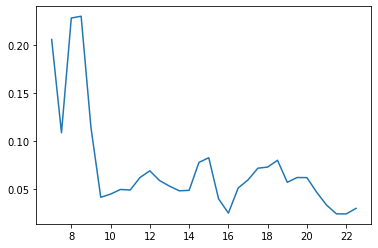

In [12]:
plt.plot(limit_indx_vec/2, np.mean(abs(reg_running_error_fr),axis=1))

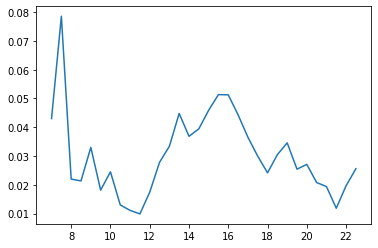

In [13]:
plt.plot(limit_indx_vec/2, np.mean(abs(reg_running_error_we),axis=1))

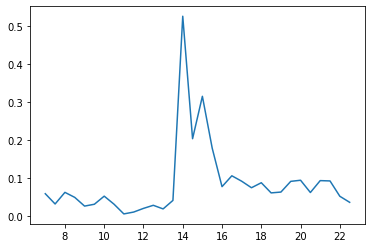

In [14]:
plt.plot(limit_indx_vec/2, np.mean(abs(reg_running_error_wd),axis=1))

In [15]:
try:
    with open('data/'+current_parking+'_modelFit.pkl','rb') as f:  # Python 3: open(..., 'rb')
        [optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
             errors_fr, optimal_params_weekendtn, errors_we]= pickle.load(f)
        f.close()
except EnvironmentError: # parent of IOError, OSError *and* WindowsError where available
    print('no saved data: recalcualting')
    bolTrainagain = Tru

In [16]:
var_weekdaytn = np.mean(errors_wd)
stdv_weekdaytn=math.sqrt(var_weekdaytn)
print('global stdv %.5f\n' % stdv_weekdaytn)
stdv_weekday30mins = np.sqrt(np.mean(errors_wd,0))
#print('stdv per time-step')
#for i in stdv_weekday30mins:
#    print('\t' + str(i))

global stdv 0.00348



In [17]:
optimal_params_weekdaytn

 final_simplex: (array([[0.29291107, 0.03415998, 0.79113299, 0.09391115],
       [0.29291127, 0.03416001, 0.79113323, 0.09391174],
       [0.29291125, 0.0341598 , 0.79113333, 0.09391085],
       [0.29291113, 0.03416041, 0.79113333, 0.09391119],
       [0.29291142, 0.03416018, 0.79113281, 0.09391166]]), array([0.01570879, 0.01570879, 0.01570879, 0.01570879, 0.01570879]))
           fun: 0.015708785409765964
       message: 'Optimization terminated successfully.'
          nfev: 256
           nit: 152
        status: 0
       success: True
             x: array([0.29291107, 0.03415998, 0.79113299, 0.09391115])

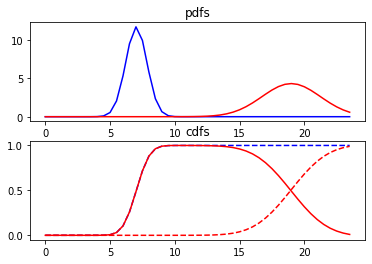

In [18]:
plot_model_tn(optimal_params_weekdaytn.x[0],optimal_params_weekdaytn.x[1],optimal_params_weekdaytn.x[2],optimal_params_weekdaytn.x[3])

In [19]:
weekday_math_params = optimal_params_weekdaytn.x
weekday_math_params

array([0.29291107, 0.03415998, 0.79113299, 0.09391115])

In [20]:
time2 = np.linspace(0,23.5,48)
time_tn=time2/24
tn1_wd=tn(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
tn2_wd=tn(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
#tn1_wd = gam(time2, optimal_params_weekday.x[0], optimal_params_weekday.x[1])
#tn2_wd = gam(time2, optimal_params_weekday.x[2], optimal_params_weekday.x[3])

#cdf1_wd_ap = generate_cdf(tn1_wd)
#cdf2_wd_ap = generate_cdf(tn2_wd)
cdf1_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
cdf2_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
#cdf1_wd = generate_cdf(tn1_wd)
#cdf2_wd = generate_cdf(tn2_wd)

resta_wd = np.array(cdf1_wd) - np.array(cdf2_wd)
prototype_math_weekday = resta_wd/sum(resta_wd)

#resta_wd_ap= np.array(cdf1_wd_ap) - np.array(cdf2_wd_ap)
#prototype_math_weekday_ap = resta_wd_ap/sum(resta_wd_ap)

#fig = plt.figure(figsize=(18,10))
#fig.suptitle("PDF and CDF for arrival and deartures - WEEKDAYS ("+current_parking+")", fontsize=20)
#plt.plot(time2, tn1_wd/sum(tn1_wd), label="Probability that a slot gets occupied")
#plt.plot(time2, tn2_wd/sum(tn2_wd),  label="Probability that a slot gets free")
#plt.plot(time2, cdf1_wd, label="Cummulative probability arrival")
#plt.plot(time2, cdf2_wd, label="Cummulative probability departure")

#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left");


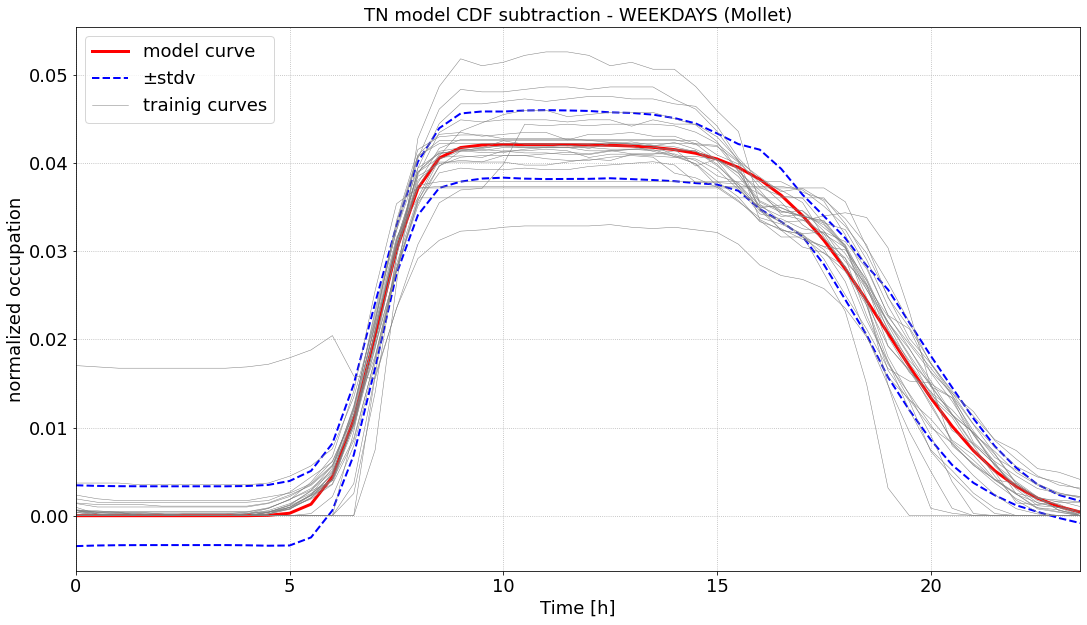

In [21]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - WEEKDAYS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_weekday-stdv_weekday30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_weekday, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_weekday+stdv_weekday30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")
#plt.plot(time2, prototype_math_weekday_ap, linewidth=3, color='red', label="approx")
for i in range(0,len(training_weekdays_norm)):
    if i==0:
        plt.plot(time, training_weekdays_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_weekdays_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'.pdf',bbox_inches='tight');
fig.savefig('Training_'+current_parking+'.png',bbox_inches='tight');

### FRIDAYS

In [22]:
var_fridaytn = np.mean(errors_fr)
stdv_fridaytn=math.sqrt(var_fridaytn)
print('global stdv %.5f\n' % stdv_fridaytn)
stdv_friday30mins = np.sqrt(np.mean(errors_fr,0))
print('stdv per time-step')
#for i in stdv_friday30mins:
#    print('\t' + str(i))

global stdv 0.00749

stdv per time-step


In [23]:
optimal_params_fridaytn

 final_simplex: (array([[0.30690624, 0.04195195, 0.77003169, 0.19340564],
       [0.30690627, 0.04195218, 0.77003165, 0.19340649],
       [0.30690612, 0.04195186, 0.77003097, 0.19340539],
       [0.30690606, 0.04195209, 0.77003185, 0.19340582],
       [0.30690605, 0.04195206, 0.77003142, 0.19340503]]), array([0.01616788, 0.01616788, 0.01616788, 0.01616788, 0.01616788]))
           fun: 0.016167878924170764
       message: 'Optimization terminated successfully.'
          nfev: 247
           nit: 143
        status: 0
       success: True
             x: array([0.30690624, 0.04195195, 0.77003169, 0.19340564])

In [24]:
#optimal_params_friday.x
#friday_math_params = optimal_params_friday.x
friday_math_params = optimal_params_fridaytn.x

In [25]:

#tn1_fri = gam(time, optimal_params_friday.x[0], optimal_params_friday.x[1])
#tn2_fri = gam(time, optimal_params_friday.x[2], optimal_params_friday.x[3])
tn1_fri=tn(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
tn2_fri=tn(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

#cdf1_fri = generate_cdf(tn1_fri)
#cdf2_fri = generate_cdf(tn2_fri)
#cdf1_fri = generate_cdf(tn1_fri)
#cdf2_fri = generate_cdf(tn2_fri)
cdf1_fri=tn_cdf(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
cdf2_fri=tn_cdf(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

resta = np.array(cdf1_fri) - np.array(cdf2_fri)
prototype_math_friday = resta/sum(resta)
#fig = plt.figure(figsize=(18,10))
#fig.suptitle("PDF and CDF for occupying and freeing a slot - FRIDAYS ("+current_parking+")", fontsize=20)
#plt.plot(time, cdf1_fri, label="CDF Slot occupied")
#plt.plot(time, cdf2_fri, label="CDF Slot free")
#plt.plot(time, tn1_fri/sum(tn1_fri), label="Probability that a slot gets occupied")
#plt.plot(time, tn2_fri/sum(tn2_fri),  label="Probability that a slot gets free")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left")

#plt.legend(fontsize=16)

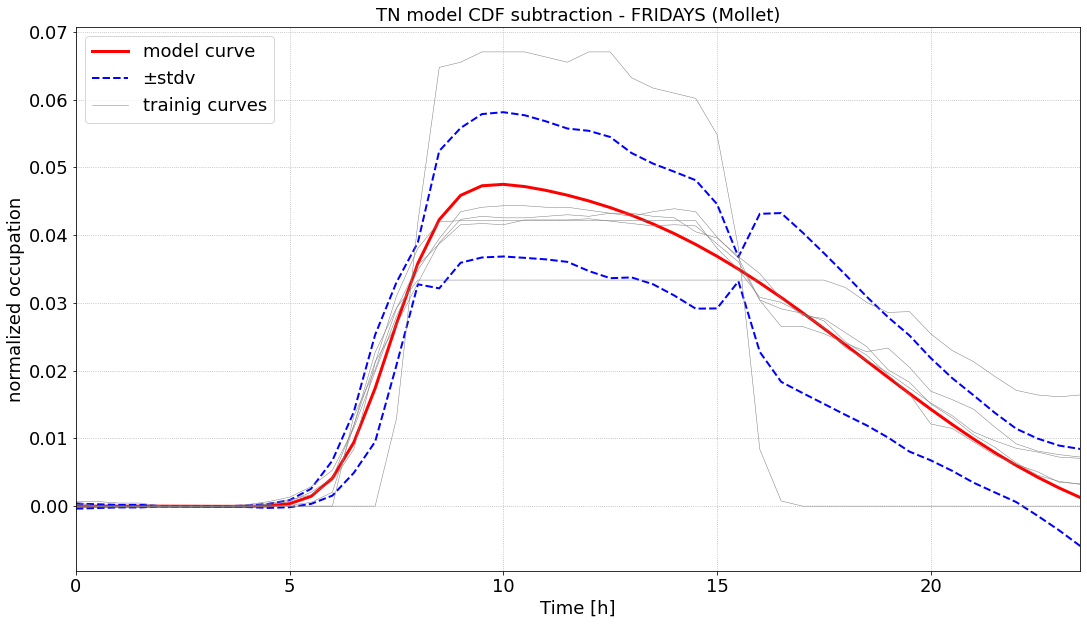

In [26]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - FRIDAYS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_friday-stdv_friday30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_friday, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_friday+stdv_friday30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")

#plt.plot(time2, prototype_math_weekday_ap, linewidth=3, color='red', label="approx")
for i in range(0,len(training_fridays_norm)):
    if i==0:
        plt.plot(time, training_fridays_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_fridays_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'_FRIDAY.pdf',bbox_inches='tight');

### WEEKENDS

## save the model fits

In [27]:
var_weekendtn = np.mean(errors_we)
stdv_weekendtn=math.sqrt(var_weekendtn)
print('global stdv %.5f\n' % stdv_weekendtn)
stdv_weekend30mins = np.sqrt(np.mean(errors_we,0))
#print('stdv per time-step')
#for i in stdv_weekend30mins:
#    print('\t' + str(i))

global stdv 0.00670



In [28]:
weekend_math_params = optimal_params_weekendtn.x
optimal_params_weekendtn.x

array([0.35668576, 0.11528907, 0.94392676, 0.0923651 ])

In [29]:
#tn1_we = gam(time, optimal_params_weekend.x[0], optimal_params_weekend.x[1])
#tn2_we = gam(time, optimal_params_weekend.x[2], optimal_params_weekend.x[3])
tn1_we=tn(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
tn2_we=tn(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])



#cdf1_we = generate_cdf(tn1_we)
#cdf2_we = generate_cdf(tn2_we)
cdf1_we = tn_cdf(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
cdf2_we = tn_cdf(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])



resta_we = np.array(cdf1_we) - np.array(cdf2_we)
prototype_math_weekend = resta_we/sum(resta_we)
#fig = plt.figure(figsize=(18,10))
#fig.suptitle("PDF and CDF for occupying and freeing a slot - WEEKENDS ("+current_parking+")", fontsize=20)
#plt.plot(time, cdf1_we, label="CDF Slot occupied")
#plt.plot(time, cdf2_we, label="CDF Slot free")
#plt.plot(time, tn1_we/sum(tn1_we), label="Probability that a slot is occupied")
#plt.plot(time, tn2_we/sum(tn2_we),  label="Probability  a slot gets free")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left")



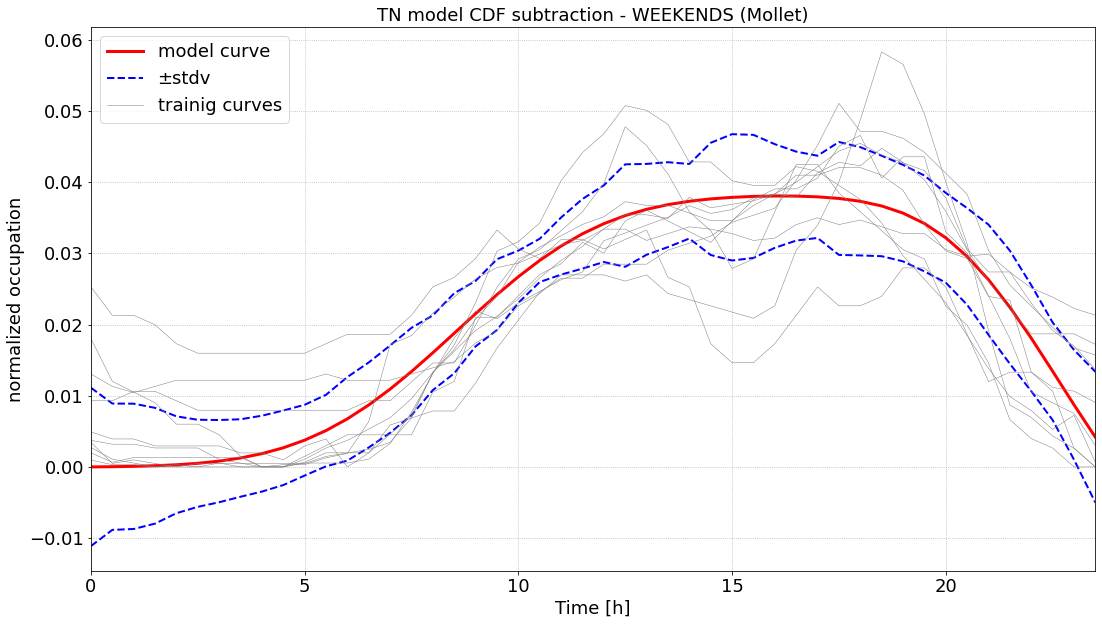

In [30]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - WEEKENDS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_weekend-stdv_weekend30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_weekend, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_weekend+stdv_weekend30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")

for i in range(0,len(training_weekends_norm)):
    if i==0:
        plt.plot(time, training_weekends_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_weekends_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'WEEKEND.pdf',bbox_inches='tight');

In [31]:
printTimes(optimal_params_weekdaytn.x,current_parking,'WEEKDAYS')
printTimes(optimal_params_fridaytn.x,current_parking,'FRIDAYS')
printTimes(optimal_params_weekendtn.x,current_parking,'WEEKENDS')

--------- WEEKDAYS Mollet -----------
Mean Arrival Time   = 07:01h
stdv Arrival        =  0:49h
Mean Departure Time = 18:59h
stdv Departure      =  2:15h
--------- FRIDAYS Mollet -----------
Mean Arrival Time   = 07:21h
stdv Arrival        =  1:00h
Mean Departure Time = 18:28h
stdv Departure      =  4:38h
--------- WEEKENDS Mollet -----------
Mean Arrival Time   = 08:33h
stdv Arrival        =  2:46h
Mean Departure Time = 22:39h
stdv Departure      =  2:13h


In [32]:
tn_weekday_n = prototype_math_weekday
tn_friday_n = prototype_math_friday
tn1_weekend_n = prototype_math_weekend

### Comparing normalized mathematical fitted prototype with testing data

### Denormalization / Rescaling

In [33]:
#**************************************WEEKDAY************************************
tn_weekday = tn_weekday_n*weekday_area + weekday_offset
#**************************************WEEKDAY************************************
tn_weekday_nooff = tn_weekday_n*weekday_area
#**************************************FRIDAY************************************
tn_friday = tn_friday_n*friday_area + friday_offset
tn_friday_nooff = tn_friday_n*friday_area 
#**************************************WEEKEND************************************
tn1_weekend = tn1_weekend_n*weekend_area + weekend_offset 
tn1_weekend_nooff = tn1_weekend_n*weekend_area

In [34]:
with open('data/'+current_parking+'_testing.pkl','rb') as f:  # Python 3: open(..., 'rb')
    [testing_mondays, testing_mondays_dates, testing_tuesdays, testing_tuesdays_dates, 
    testing_wednesdays, testing_wednesdays_dates, testing_thursdays, testing_thursdays_dates, 
    testing_fridays, testing_fridays_dates, testing_saturdays, testing_saturdays_dates,
    testing_sundays, testing_sundays_dates]= pickle.load(f)
    f.close()  
  

______ MEAN ± STDV________
4.693139851371653  ±  2.720001266889321
2.2455300972391137  ±  1.258266727588311
2.1091780020682314  ±  0.9815900000717318
2.0917436088782946  ±  1.2658773865467479
6.169258059045621  ±  2.57581848817376
1.3119501254266834  ±  0.8188159880988647
1.619716711366877  ±  1.3020565764413858


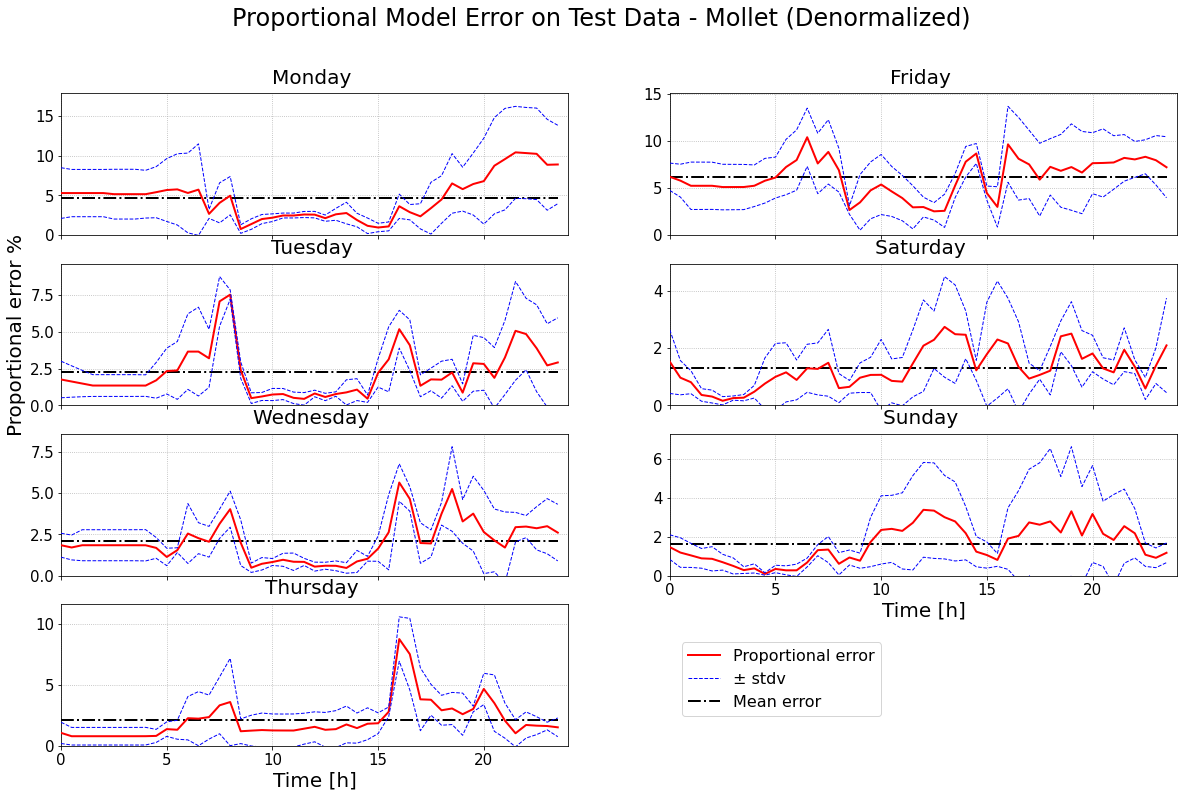

In [35]:
#[error_monday_tn,stdv_error_monday_tn] = compute_testing_prop_errorMstdv(testing_mondays, tn_weekday, max_value)
[error_monday_tn,stdv_error_monday_tn] = compute_testing_prop_errorMstdv_fit(testing_mondays, tn_weekday, max_value)
[error_tuesday_tn,stdv_error_tuesday_tn] = compute_testing_prop_errorMstdv_fit(testing_tuesdays, tn_weekday, max_value)
[error_wednesday_tn,stdv_error_wednesday_tn] = compute_testing_prop_errorMstdv_fit(testing_wednesdays, tn_weekday, max_value)
[error_thursday_tn,stdv_error_thursday_tn] = compute_testing_prop_errorMstdv_fit(testing_thursdays, tn_weekday, max_value)
[error_friday_tn,stdv_error_friday_tn] = compute_testing_prop_errorMstdv_fit(testing_fridays, tn_friday, max_value)
[error_saturday_tn,stdv_error_saturday_tn] = compute_testing_prop_errorMstdv_fit(testing_saturdays, tn1_weekend, max_value)
[error_sunday_tn,stdv_error_sunday_tn] = compute_testing_prop_errorMstdv_fit(testing_sundays, tn1_weekend, max_value)


fig, ax = plt.subplots(4, 2)
fig.set_figwidth(20)
fig.set_figheight(12)
fig.suptitle('Proportional Model Error on Test Data - '+current_parking+' (Denormalized)', fontsize=24)
time = np.linspace(0,23.5,48)

mean_Monday =  [np.mean(error_monday_tn)]*len(time)
mstdv_Monday= np.mean(stdv_error_monday_tn[~np.isnan(stdv_error_monday_tn)])
subplotCDFsubtractionStdvErr(fig, ax, 0, 0, time, error_monday_tn, stdv_error_monday_tn, mean_Monday, 
                 'Monday ', 'Monday',False,False,False,False)

mean_Tuesday =  [np.mean(error_tuesday_tn)]*len(time)
mstdv_Tuesday= np.mean(stdv_error_tuesday_tn[~np.isnan(stdv_error_tuesday_tn)])
subplotCDFsubtractionStdvErr(fig, ax, 1, 0, time, error_tuesday_tn, stdv_error_tuesday_tn,  mean_Tuesday, 
                 'Tuesday ', 'Tuesday',False,True,False,False)

mean_Wednesday =  [np.mean(error_wednesday_tn)]*len(time)
mstdv_Wednesday= np.mean(stdv_error_wednesday_tn[~np.isnan(stdv_error_wednesday_tn)])
subplotCDFsubtractionStdvErr(fig, ax, 2, 0, time, error_wednesday_tn, stdv_error_wednesday_tn, mean_Wednesday, 
                 'Wednesday ', 'Wednesday',False,False,False,False)

mean_Thursday =  [np.mean(error_thursday_tn)]*len(time)
mstdv_Thursday= np.mean(stdv_error_thursday_tn[~np.isnan(stdv_error_thursday_tn)])
subplotCDFsubtractionStdvErr(fig, ax, 3, 0, time, error_thursday_tn, stdv_error_thursday_tn, mean_Thursday, 
                 'Thursday ', 'Thursday',True,False,True,False)

mean_Friday =  [np.mean(error_friday_tn)]*len(time)
mstdv_Friday= np.mean(stdv_error_friday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 0, 1, time, error_friday_tn, stdv_error_friday_tn, mean_Friday, 
                 'Friday ', 'Friday',False,False,False,False)

mean_Saturday =  [np.mean(error_saturday_tn)]*len(time)
mstdv_Saturday= np.mean(stdv_error_saturday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 1, 1, time, error_saturday_tn, stdv_error_saturday_tn, mean_Saturday, 
                 'Saturday ', 'Saturday',False,False,False,False)

mean_Sunday =  [np.mean(error_sunday_tn)]*len(time)
mstdv_Sunday= np.mean(stdv_error_sunday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 2, 1, time, error_sunday_tn, stdv_error_sunday_tn, mean_Sunday, 
                 'Sunday ', 'Sunday',True,False,True,True)

ax[3,1].set_visible(False)
fig.savefig('TestError_'+current_parking+'.pdf',bbox_inches='tight');
#ax[2,2].set_visible(False)
#fig.tight_layout(pad=5.0)
#for ax in ax.flat:
#    ax.set_ylabel('PROPORTIONAL ERROR %', fontsize=10)
#    ax.set_xlabel('HOUR', fontsize=11)


print('______ MEAN ± STDV________')    

print( mean_Monday[0], ' ± ', mstdv_Monday)
print(mean_Tuesday[0], ' ± ', mstdv_Tuesday)
print(mean_Wednesday[0], ' ± ', mstdv_Wednesday)
print(mean_Thursday[0], ' ± ', mstdv_Thursday)
print(mean_Friday[0], ' ± ', mstdv_Friday)
print(mean_Saturday[0], ' ± ', mstdv_Saturday)
print(mean_Sunday[0], ' ± ', mstdv_Sunday)
#print('______STDV________')

#print(np.std(error_monday_tn))
#print(np.std(error_tuesday_tn))
#print(np.std(error_wednesday_tn))
#print(np.std(error_thursday_tn))
#print(np.std(error_friday_tn))
#print(np.std(error_saturday_tn))
#print(np.std(error_sunday_tn))



In [36]:
m_row=[current_parking,'meanE',mean_Monday[0], mean_Tuesday[0], mean_Wednesday[0], mean_Thursday[0],
       mean_Friday[0],mean_Saturday[0], mean_Sunday[0]]
s_row=[current_parking,'mStdvE',mstdv_Monday, mstdv_Tuesday, mstdv_Wednesday,  mstdv_Thursday, 
       mstdv_Friday, mstdv_Saturday, mstdv_Sunday]

In [37]:
f = open('data/'+current_parking+'_testError.csv', 'w')
# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
writer.writerow(m_row)
writer.writerow(s_row)

# close the file
f.close()

### MATHEMATICAL PROTOTYE: Real time prediction by SCALING

In [38]:
with open('data/'+current_parking+'_proto.pkl','rb') as f:  # Python 3: open(..., 'rb')
    [hist_weekday_proto, hist_friday_proto, hist_weekend_proto]= pickle.load(f)
    f.close() 

______ MEAN ± STDV________
4.428042567504561  ±  2.504808958612709
1.9160426703258817  ±  1.047875610472904
1.8468913554499646  ±  1.2177125282075403
2.243816981539227  ±  1.391542684654669
5.949804339280689  ±  3.213431358221961
1.2825540460417353  ±  0.7643482361514543
1.5438765322072354  ±  1.1606117596710364


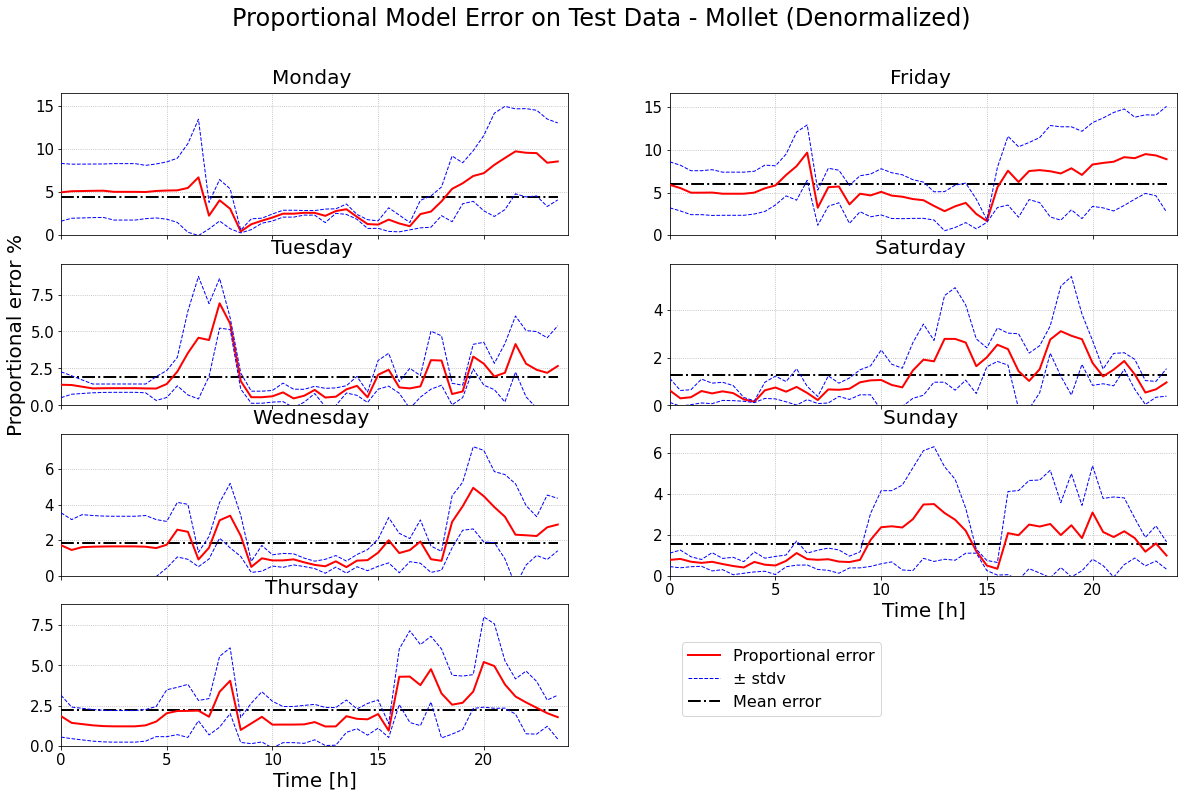

In [39]:
#[error_monday_proto,stdv_error_monday_proto] = compute_testing_prop_errorMstdv(testing_mondays, tn_weekday, max_value)
[error_monday_proto,stdv_error_monday_proto] = compute_testing_prop_errorMstdv_fit(testing_mondays, hist_weekday_proto.values, max_value)
[error_tuesday_proto,stdv_error_tuesday_proto] = compute_testing_prop_errorMstdv_fit(testing_tuesdays, hist_weekday_proto.values, max_value)
[error_wednesday_proto,stdv_error_wednesday_proto] = compute_testing_prop_errorMstdv_fit(testing_wednesdays, hist_weekday_proto.values, max_value)
[error_thursday_proto,stdv_error_thursday_proto] = compute_testing_prop_errorMstdv_fit(testing_thursdays, hist_weekday_proto.values, max_value)
[error_friday_proto,stdv_error_friday_proto] = compute_testing_prop_errorMstdv_fit(testing_fridays, hist_friday_proto.values, max_value)
[error_saturday_proto,stdv_error_saturday_proto] = compute_testing_prop_errorMstdv_fit(testing_saturdays, hist_weekend_proto.values, max_value)
[error_sunday_proto,stdv_error_sunday_proto] = compute_testing_prop_errorMstdv_fit(testing_sundays, hist_weekend_proto.values, max_value)


fig, ax = plt.subplots(4, 2)
fig.set_figwidth(20)
fig.set_figheight(12)
fig.suptitle('Proportional Model Error on Test Data - '+current_parking+' (Denormalized)', fontsize=24)
time = np.linspace(0,23.5,48)

mean_Monday_proto =  [np.mean(error_monday_proto)]*len(time)
mstdv_Monday_proto= np.mean(stdv_error_monday_proto[~np.isnan(stdv_error_monday_proto)])
subplotCDFsubtractionStdvErr(fig, ax, 0, 0, time, error_monday_proto, stdv_error_monday_proto, mean_Monday_proto, 
                 'Monday ', 'Monday',False,False,False,False)

mean_Tuesday_proto =  [np.mean(error_tuesday_proto)]*len(time)
mstdv_Tuesday_proto= np.mean(stdv_error_tuesday_proto[~np.isnan(stdv_error_tuesday_proto)])
subplotCDFsubtractionStdvErr(fig, ax, 1, 0, time, error_tuesday_proto, stdv_error_tuesday_proto,  mean_Tuesday_proto, 
                 'Tuesday ', 'Tuesday',False,True,False,False)

mean_Wednesday_proto =  [np.mean(error_wednesday_proto)]*len(time)
mstdv_Wednesday_proto= np.mean(stdv_error_wednesday_proto[~np.isnan(stdv_error_wednesday_proto)])
subplotCDFsubtractionStdvErr(fig, ax, 2, 0, time, error_wednesday_proto, stdv_error_wednesday_proto, mean_Wednesday_proto, 
                 'Wednesday ', 'Wednesday',False,False,False,False)

mean_Thursday_proto =  [np.mean(error_thursday_proto)]*len(time)
mstdv_Thursday_proto= np.mean(stdv_error_thursday_proto[~np.isnan(stdv_error_thursday_proto)])
subplotCDFsubtractionStdvErr(fig, ax, 3, 0, time, error_thursday_proto, stdv_error_thursday_proto, mean_Thursday_proto, 
                 'Thursday ', 'Thursday',True,False,True,False)

mean_Friday_proto =  [np.mean(error_friday_proto)]*len(time)
mstdv_Friday_proto= np.mean(stdv_error_friday_proto)
subplotCDFsubtractionStdvErr(fig, ax, 0, 1, time, error_friday_proto, stdv_error_friday_proto, mean_Friday_proto, 
                 'Friday ', 'Friday',False,False,False,False)

mean_Saturday_proto =  [np.mean(error_saturday_proto)]*len(time)
mstdv_Saturday_proto= np.mean(stdv_error_saturday_proto)
subplotCDFsubtractionStdvErr(fig, ax, 1, 1, time, error_saturday_proto, stdv_error_saturday_proto, mean_Saturday_proto, 
                 'Saturday ', 'Saturday',False,False,False,False)

mean_Sunday_proto =  [np.mean(error_sunday_proto)]*len(time)
mstdv_Sunday_proto = np.mean(stdv_error_sunday_proto)
subplotCDFsubtractionStdvErr(fig, ax, 2, 1, time, error_sunday_proto, stdv_error_sunday_proto, mean_Sunday_proto, 
                 'Sunday ', 'Sunday',True,False,True,True)

ax[3,1].set_visible(False)
#fig.savefig('TestError_'+current_parking+'_proto.pdf',bbox_inches='tight');
#ax[2,2].set_visible(False)
#fig.tight_layout(pad=5.0)
#for ax in ax.flat:
#    ax.set_ylabel('PROPORTIONAL ERROR %', fontsize=10)
#    ax.set_xlabel('HOUR', fontsize=11)


print('______ MEAN ± STDV________')    

print(mean_Monday_proto[0], ' ± ', mstdv_Monday_proto)
print(mean_Tuesday_proto[0], ' ± ', mstdv_Tuesday_proto)
print(mean_Wednesday_proto[0], ' ± ', mstdv_Wednesday_proto)
print(mean_Thursday_proto[0], ' ± ', mstdv_Thursday_proto)
print(mean_Friday_proto[0], ' ± ', mstdv_Friday_proto)
print(mean_Saturday_proto[0], ' ± ', mstdv_Saturday_proto)
print(mean_Sunday_proto[0], ' ± ', mstdv_Sunday_proto)
#print('______STDV________')





In [40]:
m_row_proto=[current_parking,'meanE_proto',mean_Monday_proto[0], mean_Tuesday_proto[0], mean_Wednesday_proto[0], mean_Thursday_proto[0],
       mean_Friday_proto[0],mean_Saturday_proto[0], mean_Sunday_proto[0]]
s_row_proto=[current_parking,'mStdvE_proto',mstdv_Monday_proto, mstdv_Tuesday_proto, mstdv_Wednesday_proto,  mstdv_Thursday_proto, 
       mstdv_Friday_proto, mstdv_Saturday_proto, mstdv_Sunday_proto]

In [41]:
f = open('data/'+current_parking+'_testError_proto.csv', 'w')
# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
writer.writerow(m_row_proto)
writer.writerow(s_row_proto)

# close the file
f.close()

#### MONDAY

In [42]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday_nooff
t_days = testing_mondays
t_dates=testing_mondays_dates
limit_hour = 14
day = 'Monday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-02-24
Real Monday scaled prototype error:  13.07 %
Real Monday scaled prototype error (median):  12.65 %
Real Monday scaled prototype STDV: 9.970414289057627
Real Monday scaled TN error:  13.99 %
Real Monday scaled TN error (median):  12.1 %
Real Monday scaled TN STDV:  10.558163676298891
_____________________________________________________________
2020-03-02
Real Monday scaled prototype error:  3.02 %
Real Monday scaled prototype error (median):  2.16 %
Real Monday scaled prototype STDV: 2.3278720846641594
Real Monday scaled TN error:  3.77 %
Real Monday scaled TN error (median):  2.05 %
Real Monday scaled TN STDV:  3.2658143541206197
_____________________________________________________________
2020-03-09
Real Monday scaled prototype error:  7.62 %
Real Monday scaled prototype error (median):  9.42 %
Real Monday scaled prototype STDV: 4.425036681504452
Real Monday scaled TN error:  7.01 %
Real Monday scaled TN error (median):  8.54 %
Real Monday scaled TN STDV:  3.9083997419467

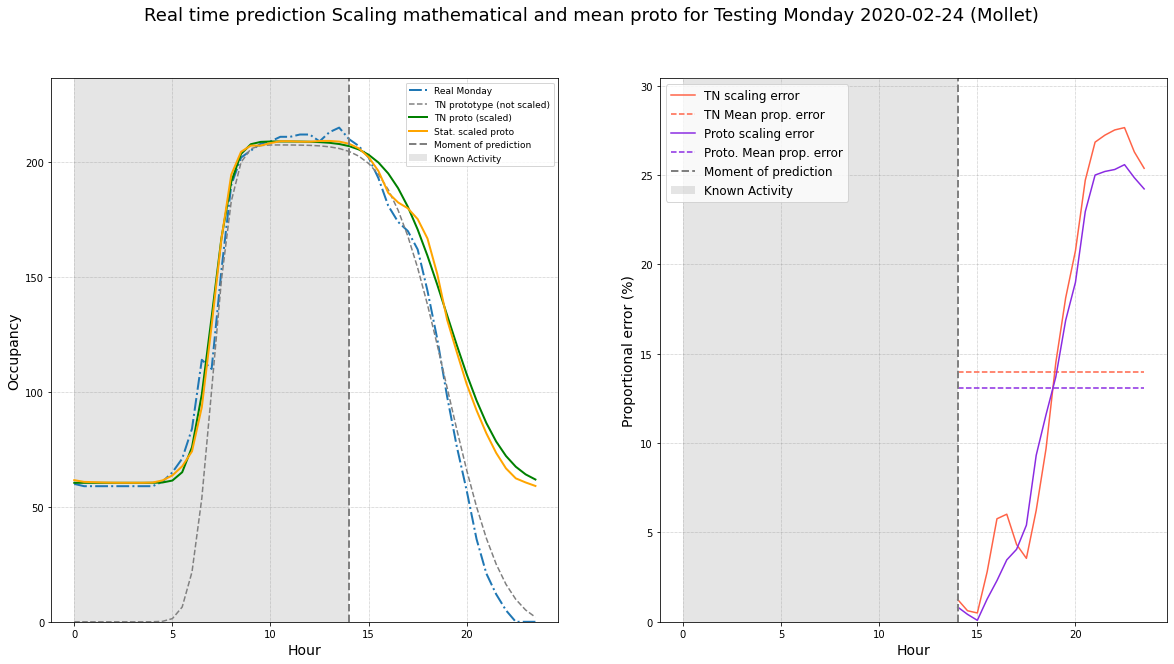

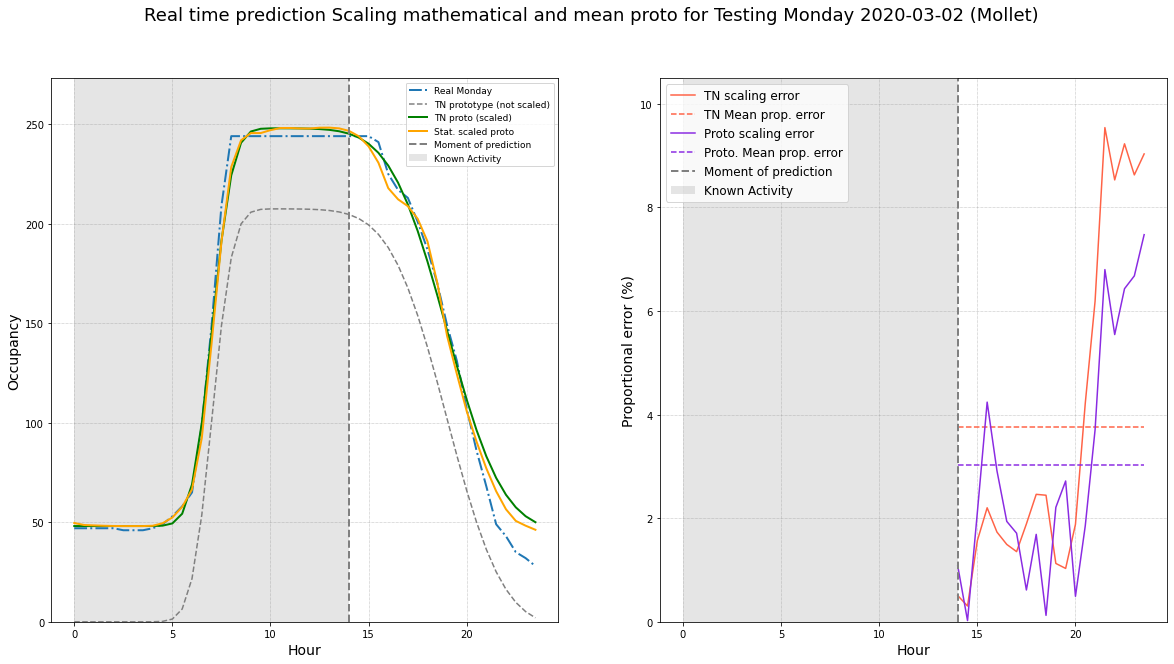

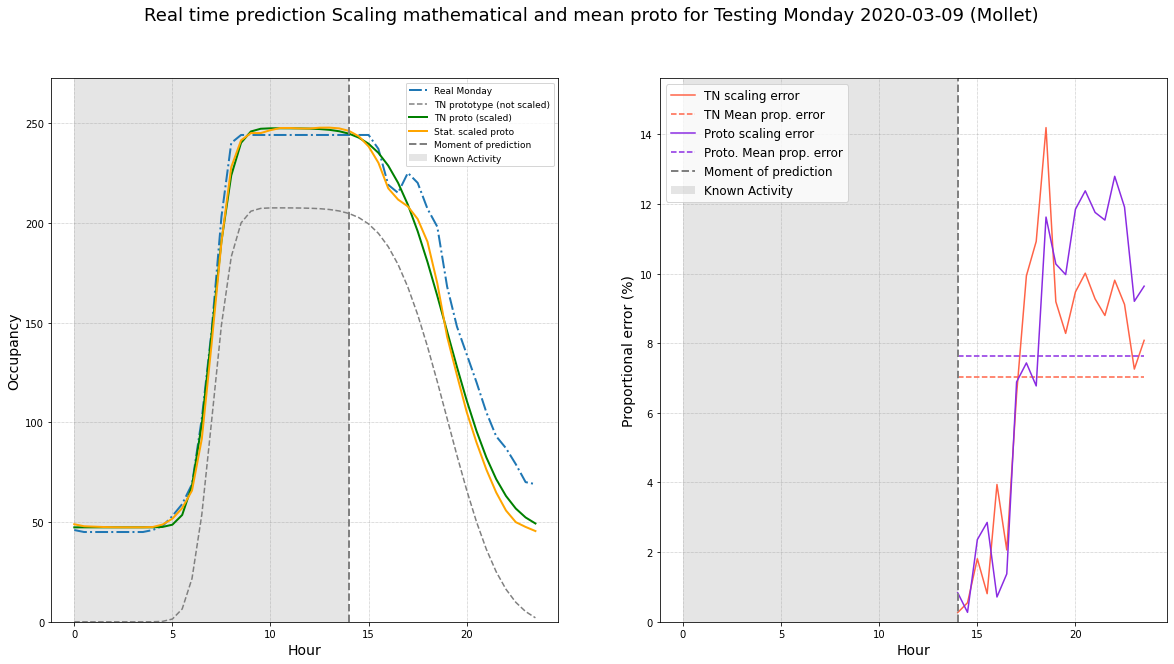

In [43]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], hist_weekday_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

In [44]:
starting_hour=7

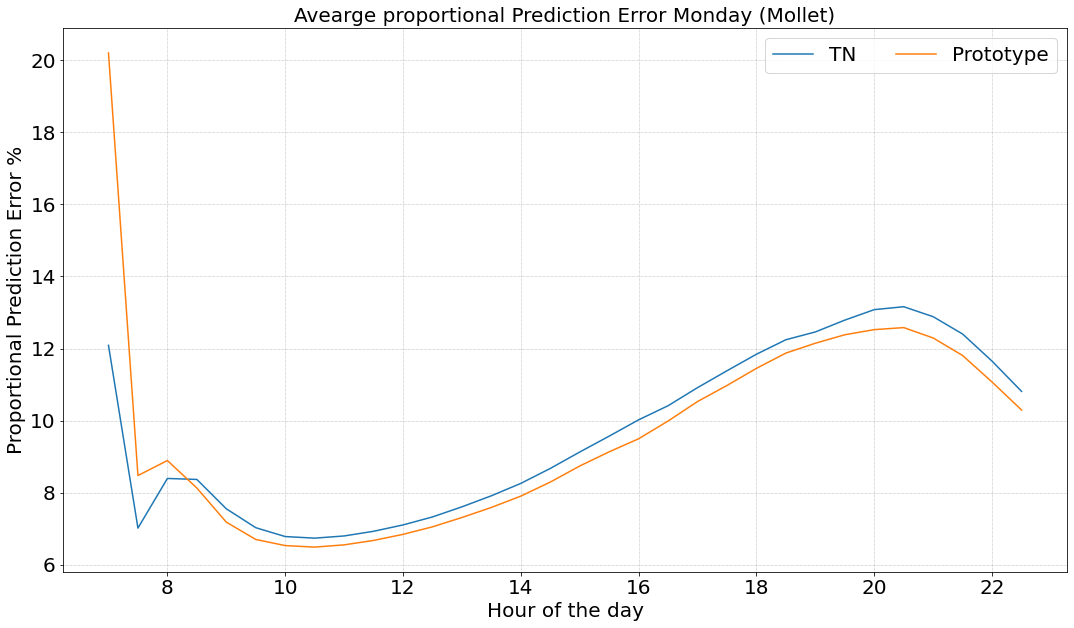

In [45]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,hist_weekday_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [46]:
proto_running_error_wd=proto_running_error_vec
tn_running_error_wd=tn_running_error_vec

2020-02-24
Real Monday scaled prototype error:  5.69 %
Real Monday scaled prototype error (median):  6.08 %
Real Monday scaled prototype STDV: 4.202070126455367
Real Monday scaled TN error:  6.13 %
Real Monday scaled TN error (median):  5.92 %
Real Monday scaled TN STDV:  4.349455049203509
_____________________________________________________________
2020-03-02
Real Monday scaled prototype error:  3.79 %
Real Monday scaled prototype error (median):  3.74 %
Real Monday scaled prototype STDV: 2.24961070136498
Real Monday scaled TN error:  3.32 %
Real Monday scaled TN error (median):  2.75 %
Real Monday scaled TN STDV:  2.4890756019025804
_____________________________________________________________
2020-03-09
Real Monday scaled prototype error:  12.23 %
Real Monday scaled prototype error (median):  15.31 %
Real Monday scaled prototype STDV: 7.182895599402675
Real Monday scaled TN error:  12.06 %
Real Monday scaled TN error (median):  14.84 %
Real Monday scaled TN STDV:  7.464903031367556

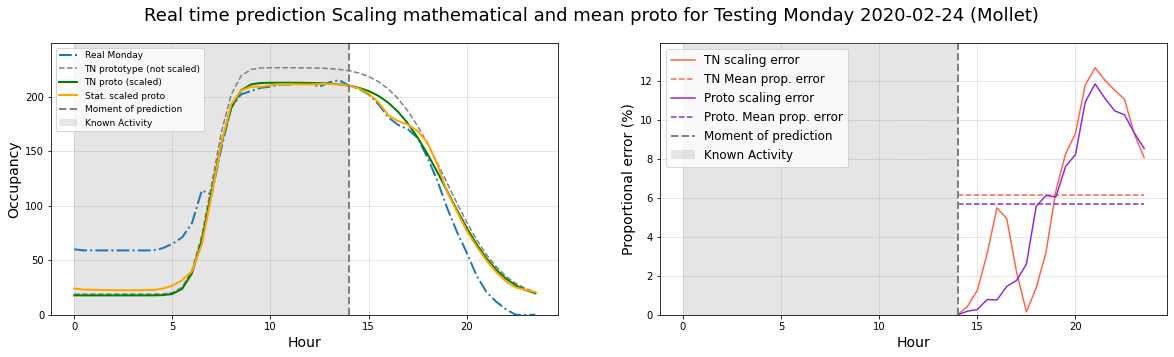

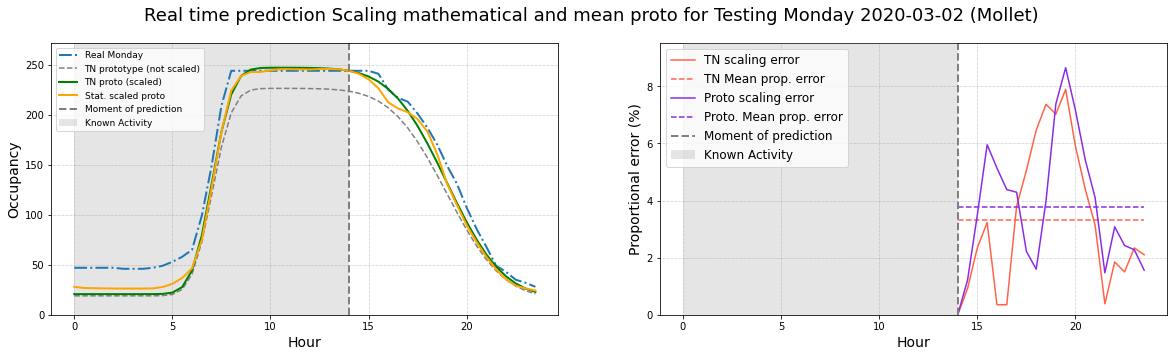

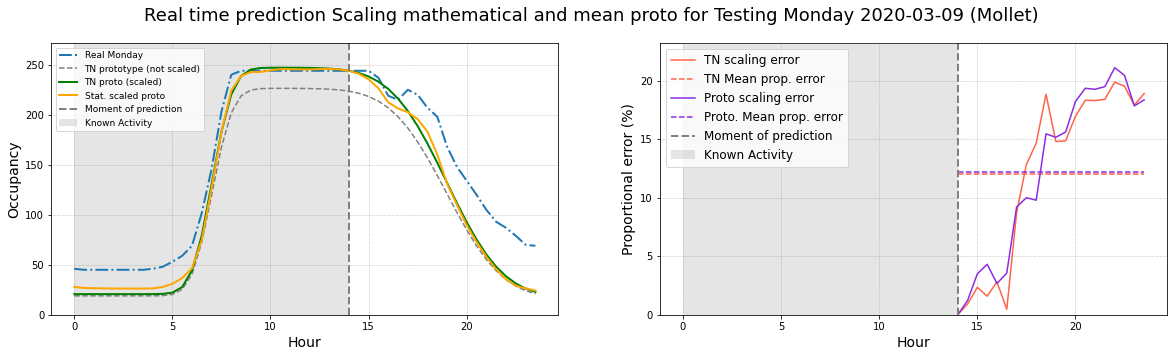

In [47]:
tn_proto = tn_weekday
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(5)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

2020-02-24


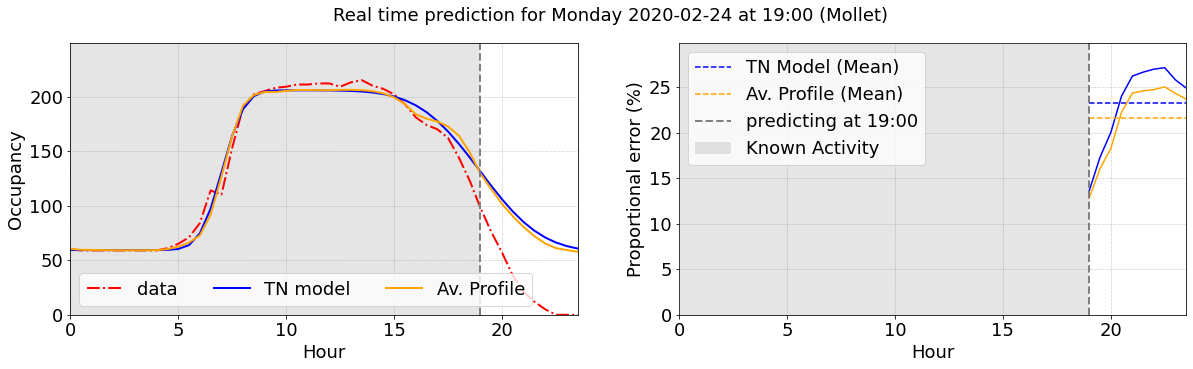

In [48]:
limit_hour = 19
fsize=18


if isinstance(limit_hour, int):
    hourstring = str(limit_hour) + ':00'
else:
    hourstring = str(int(limit_hour))+':'+str(int((limit_hour-int(limit_hour))*60))

cont=0
i=0



t_date=t_dates[cont]
print(t_date)
tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], hist_weekday_proto.values)
scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]


#scaled_stat_proto = statistic_proto.values 
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(20)
fig.set_figheight(5)
axx=0;
time = np.linspace(0,23.5,48)
fig.suptitle('Real time prediction for '
             + day + ' ' +t_date + ' at '+ hourstring +' ('+ current_parking+')', fontsize=fsize)
ax[axx].plot(time, t_days[i].values, linestyle='dashdot', color='red', linewidth=2, label='data')

ax[axx].plot(time, scaled_tn_proto, color='blue', linewidth=2 , label='TN model')
ax[axx].plot(time, scaled_stat_proto, color='orange', linewidth=2, label='Av. Profile')
ax[axx].axvline(x=limit_hour, linestyle='--', color='grey', linewidth=2)
ax[axx].axvspan(0, limit_hour, facecolor='grey', alpha=0.2)
ax[axx].grid(linestyle='dotted', linewidth='0.5', color='grey')
ax[axx].legend(fontsize=fsize, loc="best",ncol=3)
ax[axx].set_ylim([0,1.1*max([max(t_days[i].values),max(tn_proto),max(scaled_tn_proto),
                             max(scaled_stat_proto)])])
ax[axx].set_xlabel('Hour', fontsize=fsize)
ax[axx].set_xlim([0,23.5])
ax[axx].set_ylabel('Occupancy', fontsize=fsize)
ax[axx].tick_params(axis='x', labelsize=fsize)
ax[axx].tick_params(axis='y', labelsize=fsize)
axx=1;



limit_hourIdx = int(limit_hour*2)
tn_scaled_error = (np.absolute((np.array(scaled_tn_proto) - np.array(t_days[i].values)))/max_value)*100
mean_scaled_error = (np.absolute((np.array(scaled_stat_proto) - np.array(t_days[i].values)))/max_value)*100

#tn_scaled_error = (np.absolute((np.array(scaled_tn_proto) - np.array(t_days[i].values)))/np.array(t_days[i].values))*100
#mean_scaled_error = (np.absolute((np.array(scaled_stat_proto) - np.array(t_days[i].values)))/np.array(t_days[i].values))*100

tn_s_error_mean = [np.mean(tn_scaled_error[limit_hourIdx:])]*len(tn_scaled_error)
mean_s_error_mean = [np.mean(mean_scaled_error[limit_hourIdx:])]*len(mean_scaled_error)

#Second plot
#     time = time[limit_hour:]
ax[axx].plot(time[limit_hourIdx:], tn_scaled_error[limit_hourIdx:], color='blue')#, label='TN Model')
ax[axx].plot(time[limit_hourIdx:],tn_s_error_mean[limit_hourIdx:], '--',color='blue', label='TN Model (Mean)')
ax[axx].plot(time[limit_hourIdx:],mean_scaled_error[limit_hourIdx:], color='orange') #, label='Average Profile')
ax[axx].plot(time[limit_hourIdx:],mean_s_error_mean[limit_hourIdx:], '--',color='orange', label='Av. Profile (Mean)')
ax[axx].grid(linestyle='dotted', linewidth='0.5', color='grey')
ax[axx].axvline(x=limit_hour, linestyle='--', color='grey', linewidth=2, label='predicting at '+ hourstring)
ax[axx].axvspan(0, limit_hour, facecolor='grey', alpha=0.2, zorder=4, label='Known Activity')
ax[axx].legend(fontsize=fsize, loc="best",ncol=1)
ax[axx].set_ylim([0,1.1*max(max(tn_scaled_error[limit_hourIdx:]),max(mean_scaled_error[limit_hourIdx:]))])
ax[axx].set_xlabel('Hour', fontsize=fsize)
ax[axx].set_xlim([0,23.5])
ax[axx].set_ylabel('Proportional error (%)', fontsize=fsize);
ax[axx].tick_params(axis='x', labelsize=fsize)
ax[axx].tick_params(axis='y', labelsize=fsize)

fig.savefig('ExamplePrediction_'+current_parking+'_'+hourstring.replace(':','h') +'.pdf',bbox_inches='tight');

#### TUESDAY

In [49]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday_nooff
t_days = testing_tuesdays
t_dates= testing_tuesdays_dates
limit_hour = 10
day = 'Tuesday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-02-25
Real Tuesday scaled prototype error:  2.32 %
Real Tuesday scaled prototype error (median):  2.27 %
Real Tuesday scaled prototype STDV: 1.4528524269071368
Real Tuesday scaled TN error:  2.84 %
Real Tuesday scaled TN error (median):  2.21 %
Real Tuesday scaled TN STDV:  2.273670244643971
_____________________________________________________________
2020-03-03
Real Tuesday scaled prototype error:  3.64 %
Real Tuesday scaled prototype error (median):  3.92 %
Real Tuesday scaled prototype STDV: 2.0089401363007893
Real Tuesday scaled TN error:  3.41 %
Real Tuesday scaled TN error (median):  3.45 %
Real Tuesday scaled TN STDV:  2.4285134770649712
_____________________________________________________________
2020-03-10
Real Tuesday scaled prototype error:  5.57 %
Real Tuesday scaled prototype error (median):  4.94 %
Real Tuesday scaled prototype STDV: 2.2076413148704512
Real Tuesday scaled TN error:  6.18 %
Real Tuesday scaled TN error (median):  4.64 %
Real Tuesday scaled TN STDV: 

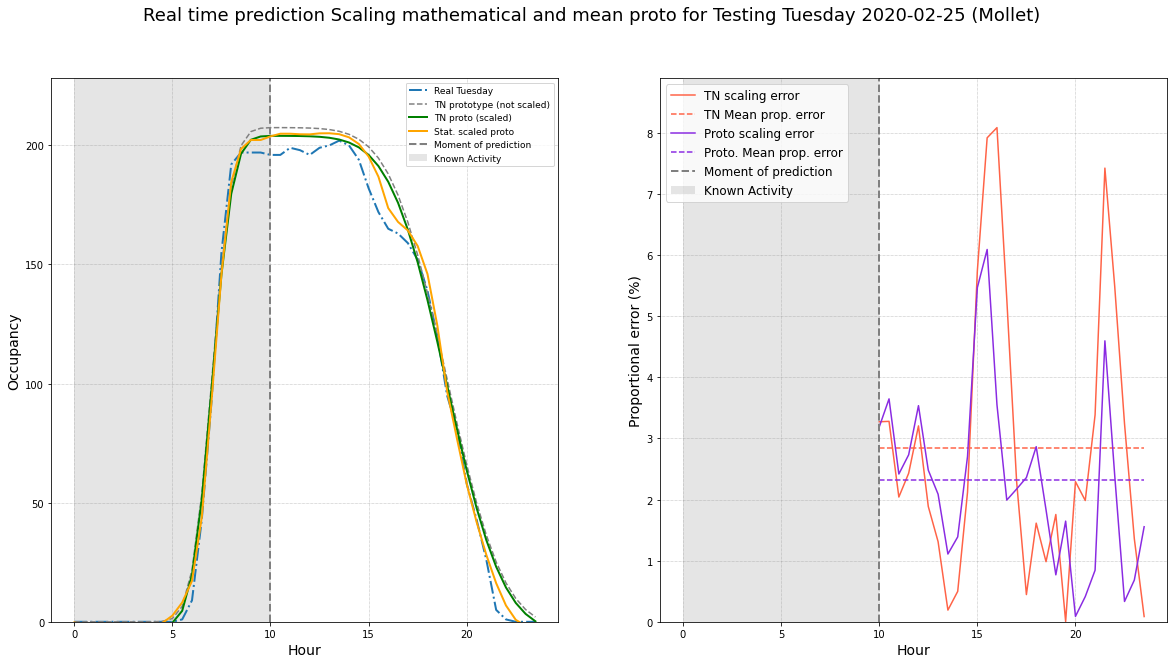

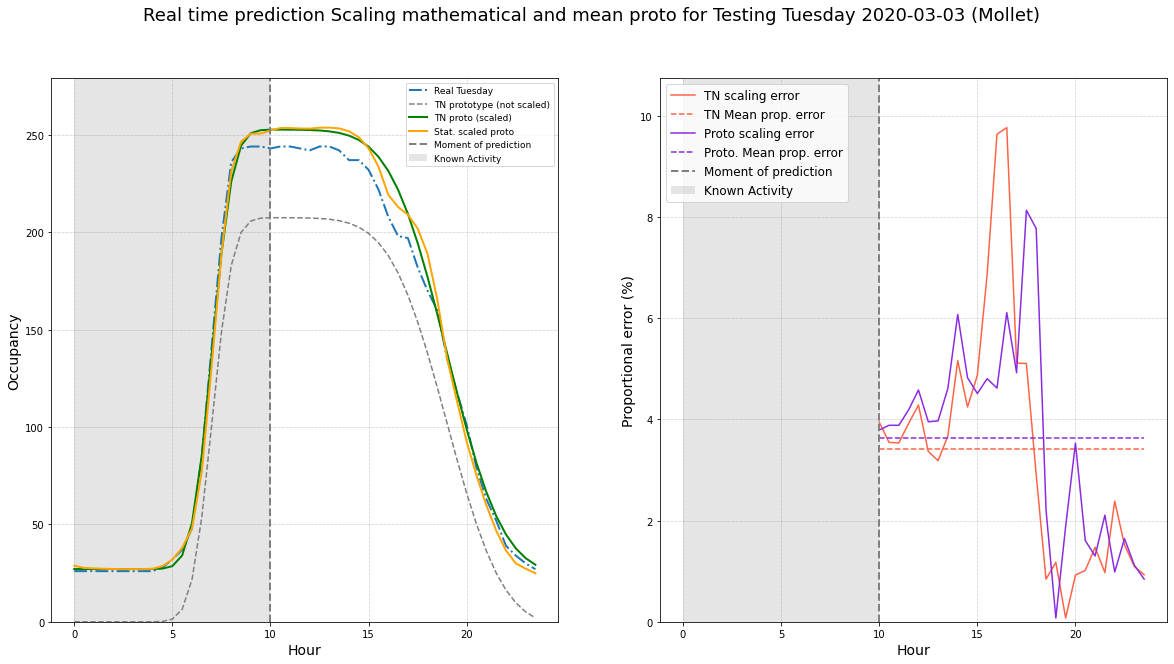

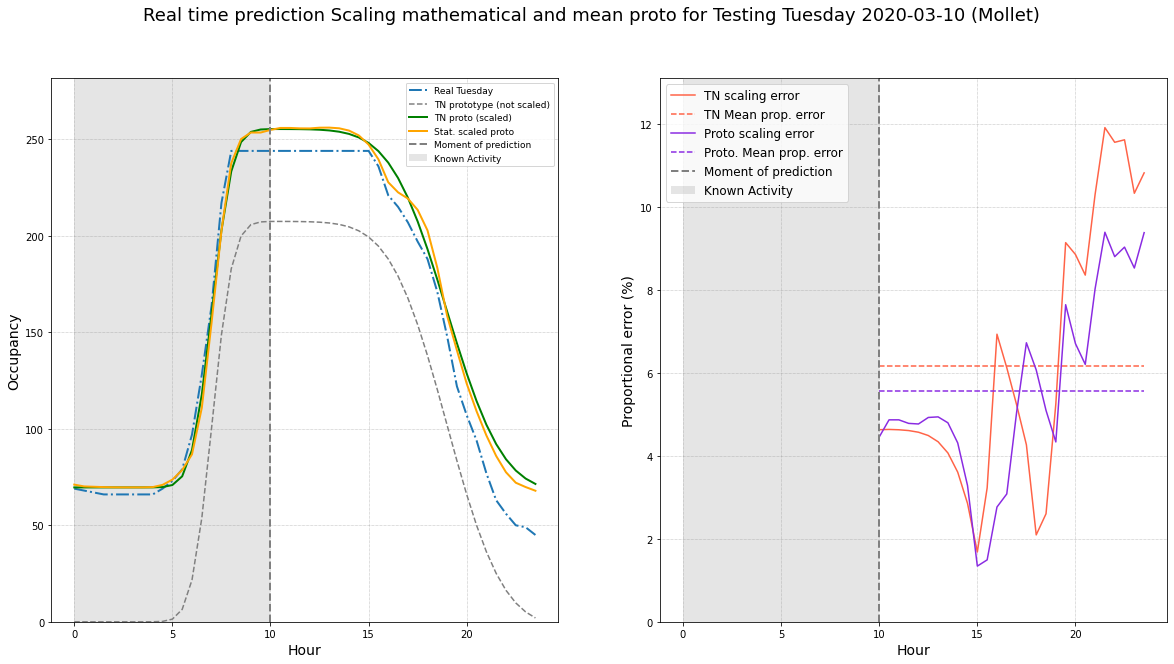

In [50]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], hist_weekday_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

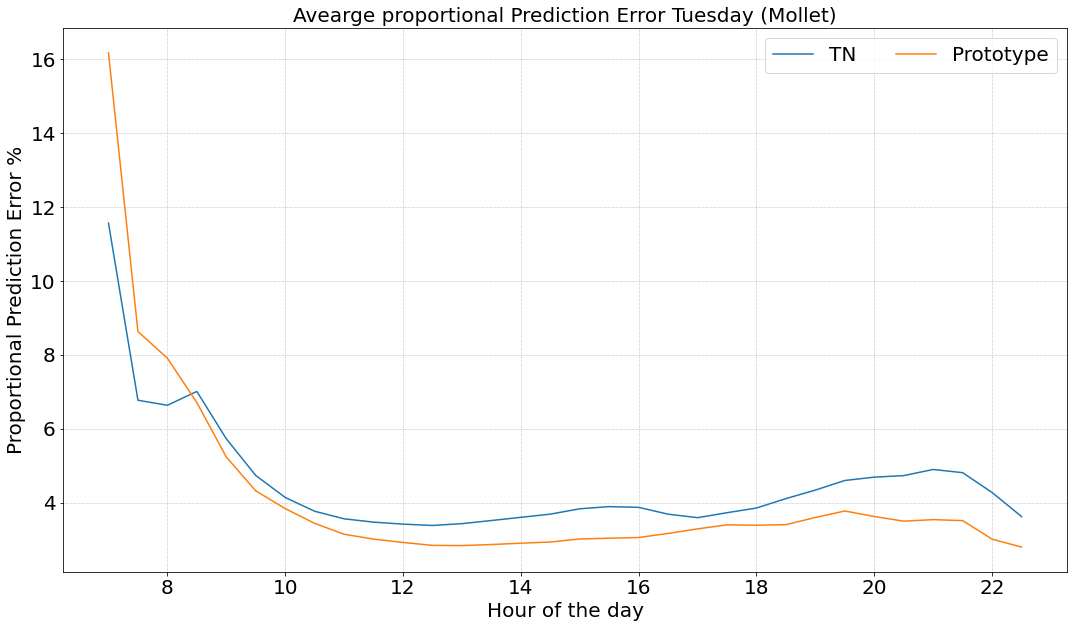

In [51]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,hist_weekday_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [52]:
proto_running_error_wd=np.concatenate((proto_running_error_wd, proto_running_error_vec), axis=1)
tn_running_error_wd=np.concatenate((tn_running_error_wd, tn_running_error_vec), axis=1)

2020-02-25
Real Tuesday scaled prototype error:  3.78 %
Real Tuesday scaled prototype error (median):  2.5 %
Real Tuesday scaled prototype STDV: 3.5749986353827654
Real Tuesday scaled TN error:  4.07 %
Real Tuesday scaled TN error (median):  2.94 %
Real Tuesday scaled TN STDV:  3.7872186144796354
_____________________________________________________________
2020-03-03
Real Tuesday scaled prototype error:  1.74 %
Real Tuesday scaled prototype error (median):  1.42 %
Real Tuesday scaled prototype STDV: 1.4708031692530719
Real Tuesday scaled TN error:  1.72 %
Real Tuesday scaled TN error (median):  1.35 %
Real Tuesday scaled TN STDV:  1.6134885195438162
_____________________________________________________________
2020-03-10
Real Tuesday scaled prototype error:  3.83 %
Real Tuesday scaled prototype error (median):  3.65 %
Real Tuesday scaled prototype STDV: 3.2786508076423604
Real Tuesday scaled TN error:  3.89 %
Real Tuesday scaled TN error (median):  2.96 %
Real Tuesday scaled TN STDV: 

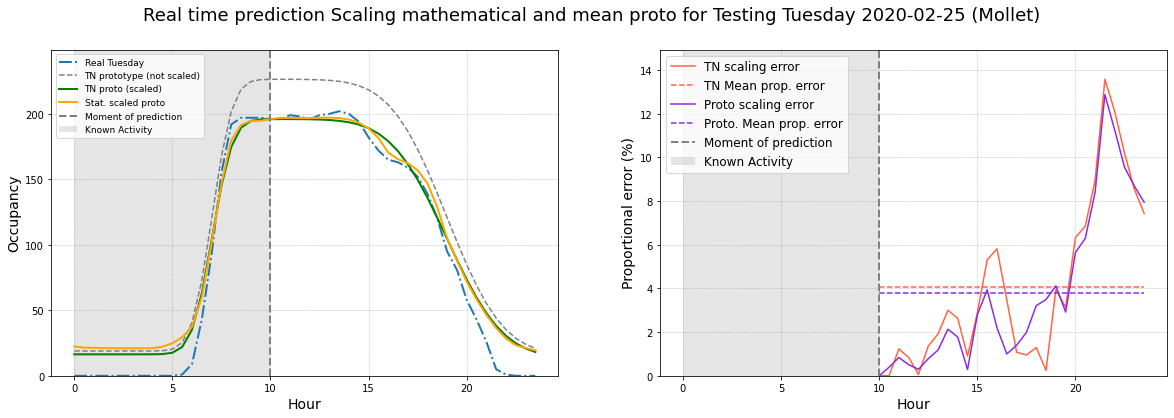

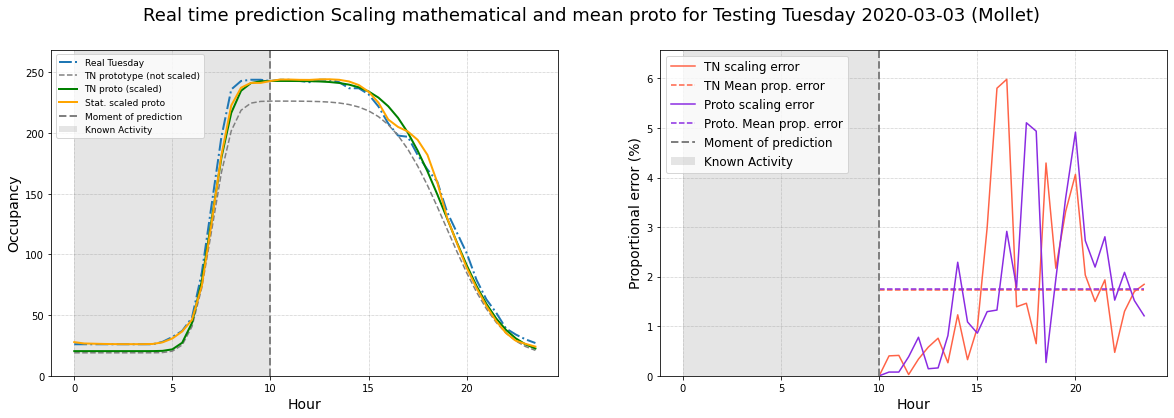

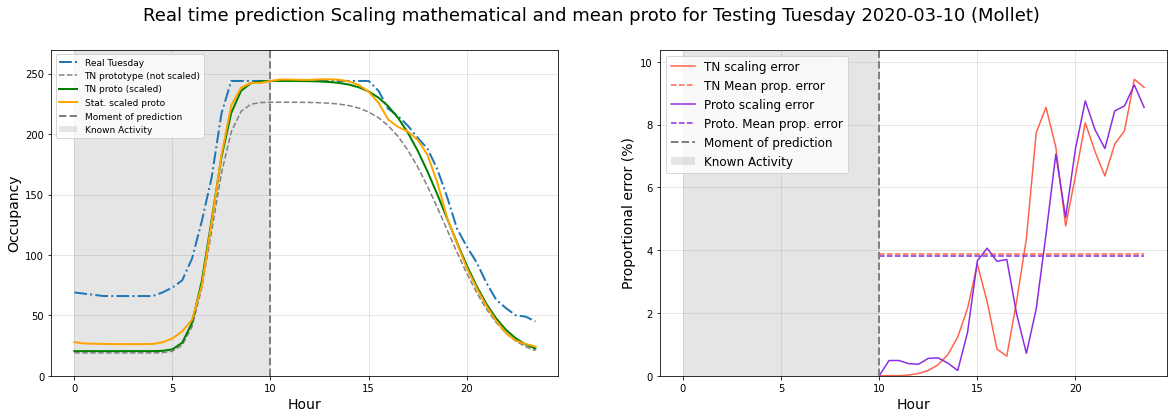

In [53]:
tn_proto = tn_weekday
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

### WEDNESDAY

In [54]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday_nooff
t_days = testing_wednesdays
t_dates= testing_wednesdays_dates
limit_hour = 13
day = 'Wednesday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-02-26
Real Wednesday scaled prototype error:  2.03 %
Real Wednesday scaled prototype error (median):  2.1 %
Real Wednesday scaled prototype STDV: 1.0844914685586036
Real Wednesday scaled TN error:  2.29 %
Real Wednesday scaled TN error (median):  2.06 %
Real Wednesday scaled TN STDV:  1.8210513468726368
_____________________________________________________________
2020-03-04
Real Wednesday scaled prototype error:  4.81 %
Real Wednesday scaled prototype error (median):  4.73 %
Real Wednesday scaled prototype STDV: 3.820708625243212
Real Wednesday scaled TN error:  4.67 %
Real Wednesday scaled TN error (median):  5.38 %
Real Wednesday scaled TN STDV:  2.5865502222705112
_____________________________________________________________
2020-03-11
Real Wednesday scaled prototype error:  1.57 %
Real Wednesday scaled prototype error (median):  1.34 %
Real Wednesday scaled prototype STDV: 1.2194666549432198
Real Wednesday scaled TN error:  2.5 %
Real Wednesday scaled TN error (median):  1.94

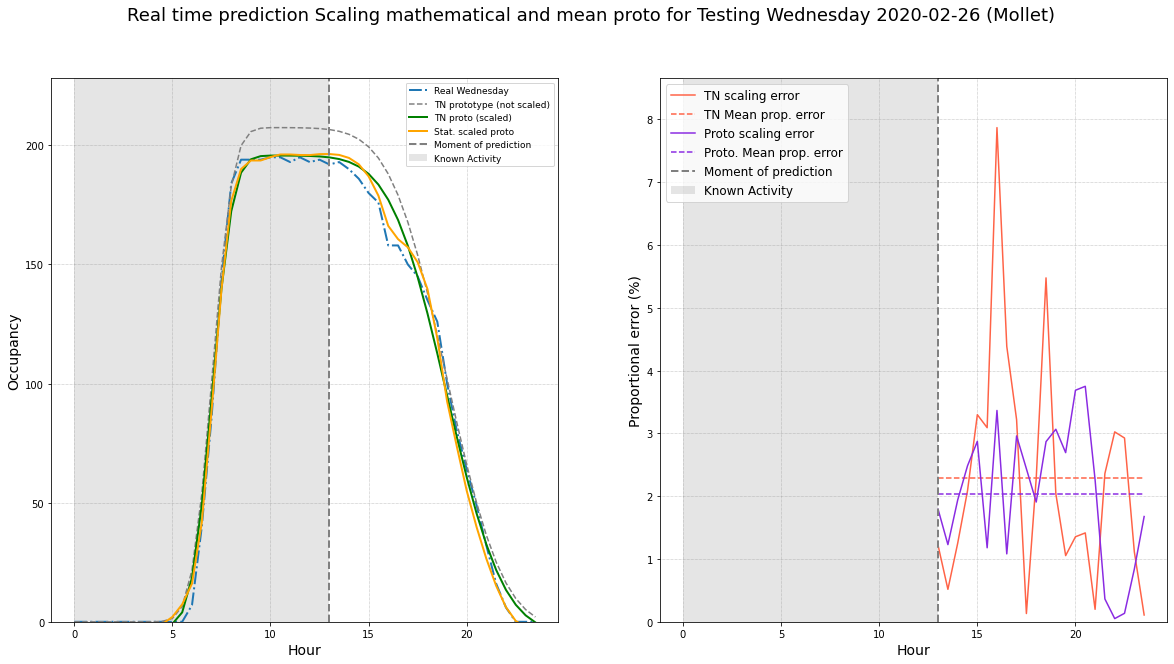

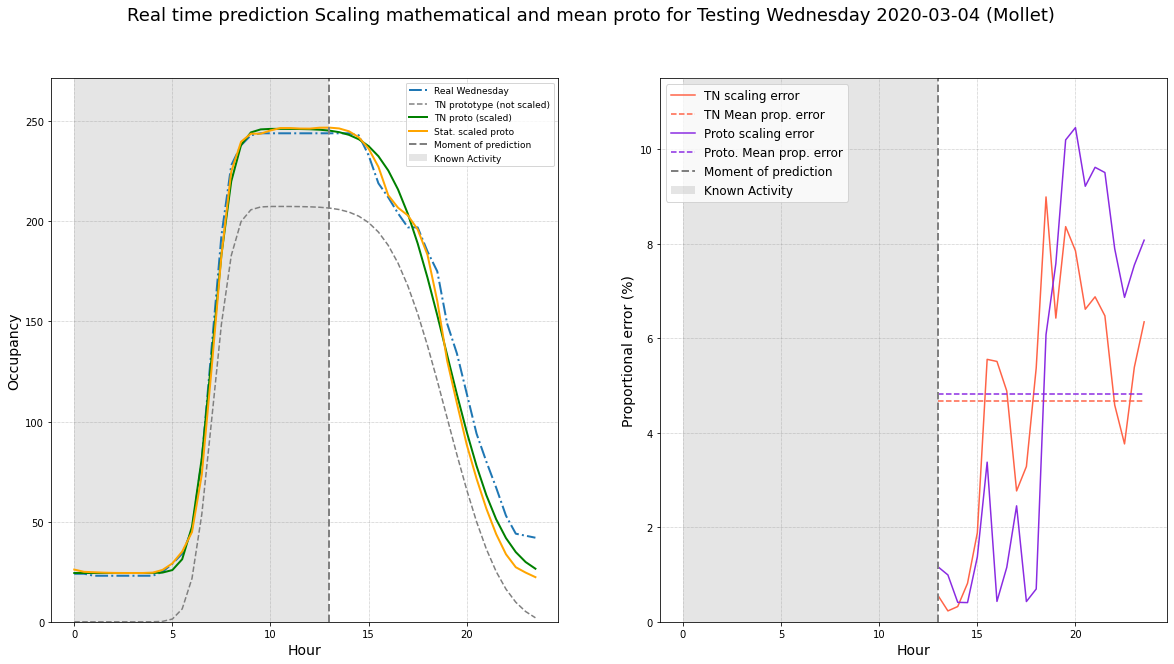

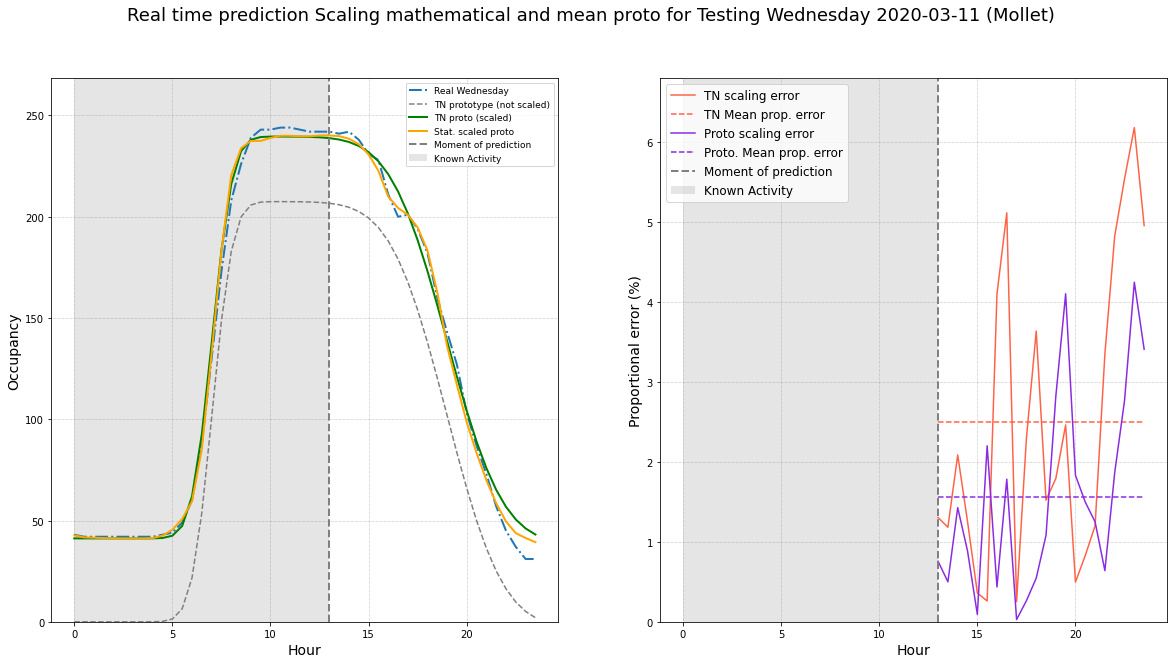

In [55]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], hist_weekday_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

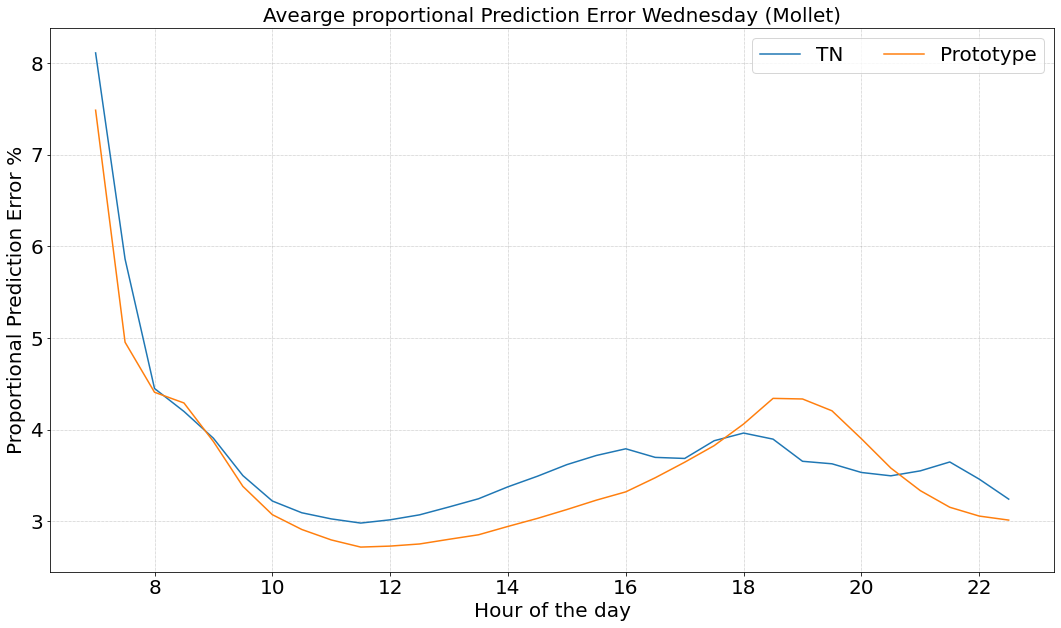

In [56]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,hist_weekday_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [57]:
proto_running_error_wd=np.concatenate((proto_running_error_wd, proto_running_error_vec), axis=1)
tn_running_error_wd=np.concatenate((tn_running_error_wd, tn_running_error_vec), axis=1)

2020-02-26
Real Wednesday scaled prototype error:  3.42 %
Real Wednesday scaled prototype error (median):  2.81 %
Real Wednesday scaled prototype STDV: 3.0524334452985933
Real Wednesday scaled TN error:  4.02 %
Real Wednesday scaled TN error (median):  3.21 %
Real Wednesday scaled TN STDV:  3.2220390029675747
_____________________________________________________________
2020-03-04
Real Wednesday scaled prototype error:  4.53 %
Real Wednesday scaled prototype error (median):  4.29 %
Real Wednesday scaled prototype STDV: 3.78178575283138
Real Wednesday scaled TN error:  5.31 %
Real Wednesday scaled TN error (median):  5.7 %
Real Wednesday scaled TN STDV:  3.093022706163016
_____________________________________________________________
2020-03-11
Real Wednesday scaled prototype error:  2.66 %
Real Wednesday scaled prototype error (median):  1.65 %
Real Wednesday scaled prototype STDV: 2.455667126829406
Real Wednesday scaled TN error:  3.17 %
Real Wednesday scaled TN error (median):  3.5 %


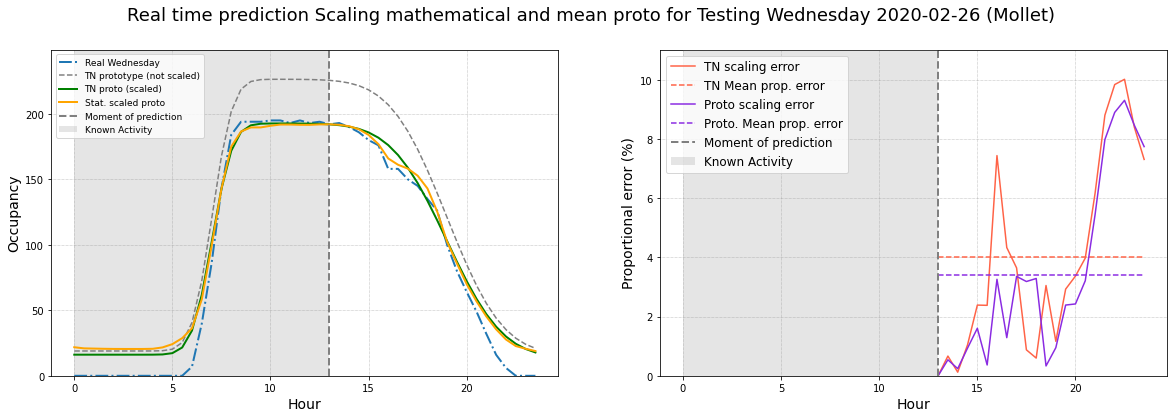

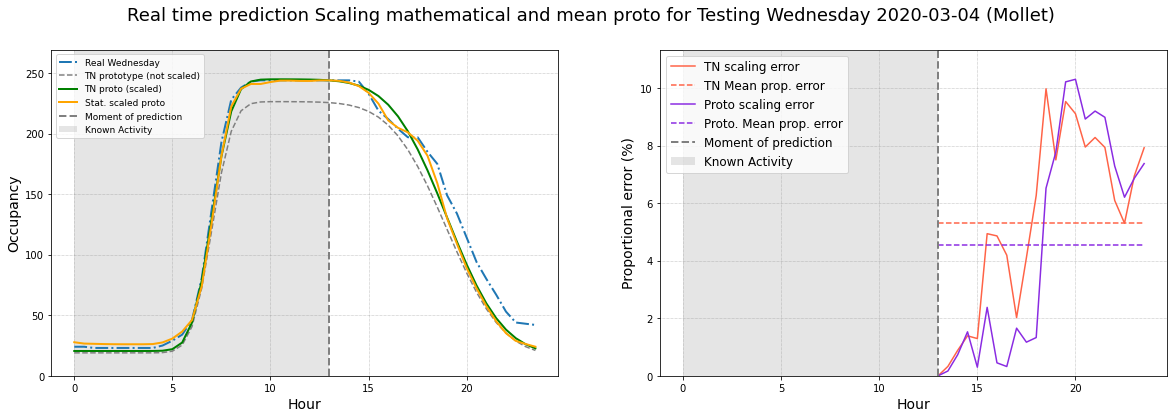

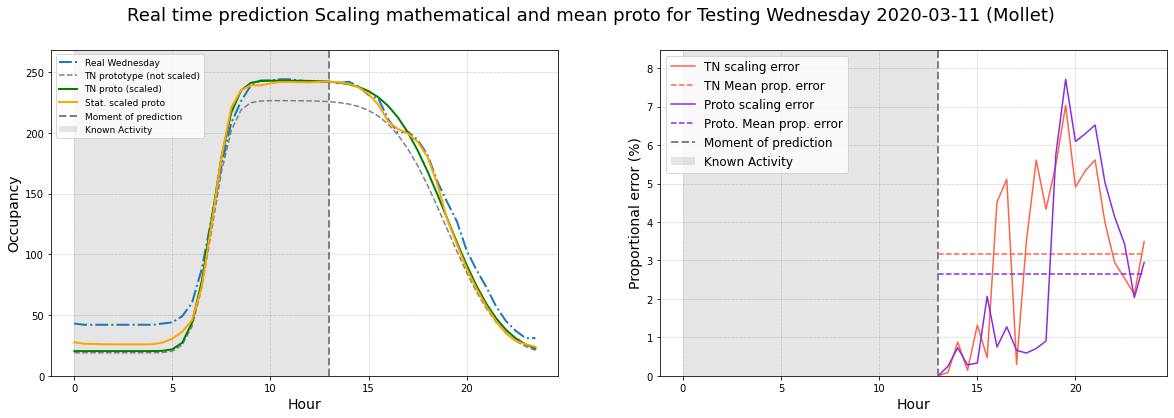

In [58]:
tn_proto = tn_weekday
cont=0        
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

### THURSDAY

In [59]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday_nooff
t_days = testing_thursdays
t_dates= testing_thursdays_dates
limit_hour = 7.5
day = 'Thursday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-02-27
Real Thursday scaled prototype error:  6.07 %
Real Thursday scaled prototype error (median):  6.57 %
Real Thursday scaled prototype STDV: 2.3218826201146543
Real Thursday scaled TN error:  9.54 %
Real Thursday scaled TN error (median):  11.22 %
Real Thursday scaled TN STDV:  4.184276420840613
_____________________________________________________________
2020-03-05
Real Thursday scaled prototype error:  7.55 %
Real Thursday scaled prototype error (median):  8.43 %
Real Thursday scaled prototype STDV: 3.0229773849731956
Real Thursday scaled TN error:  3.42 %
Real Thursday scaled TN error (median):  2.64 %
Real Thursday scaled TN STDV:  2.4671993868788142
_____________________________________________________________
2020-03-12
Real Thursday scaled prototype error:  3.0 %
Real Thursday scaled prototype error (median):  2.08 %
Real Thursday scaled prototype STDV: 2.5707582090735746
Real Thursday scaled TN error:  4.09 %
Real Thursday scaled TN error (median):  3.69 %
Real Thursda

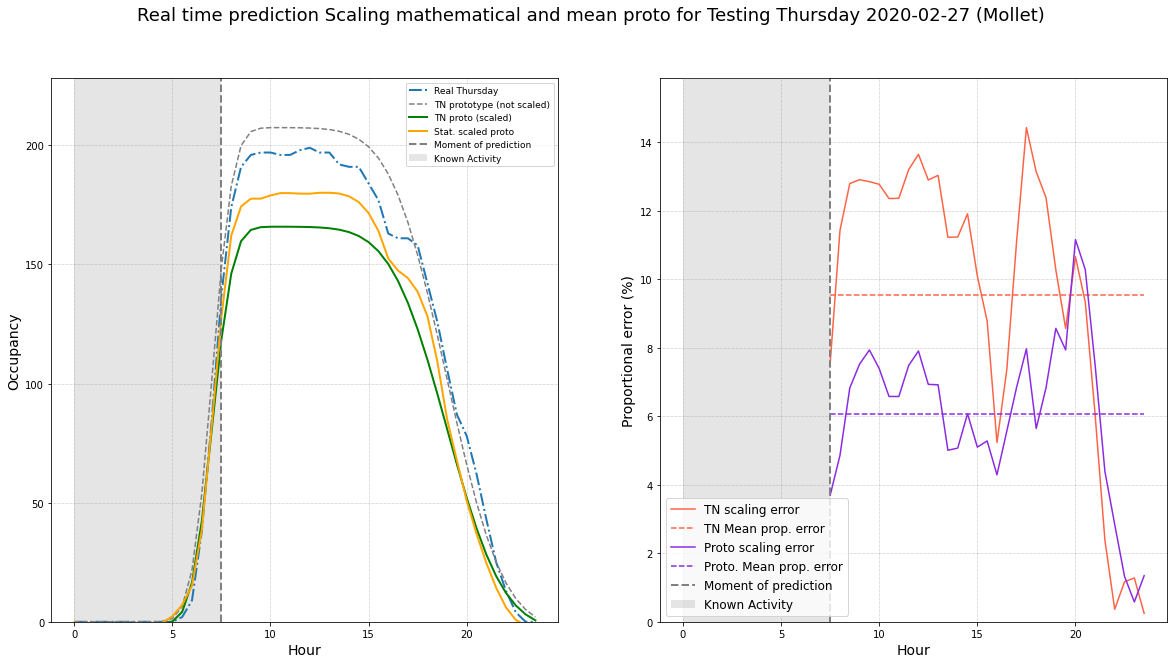

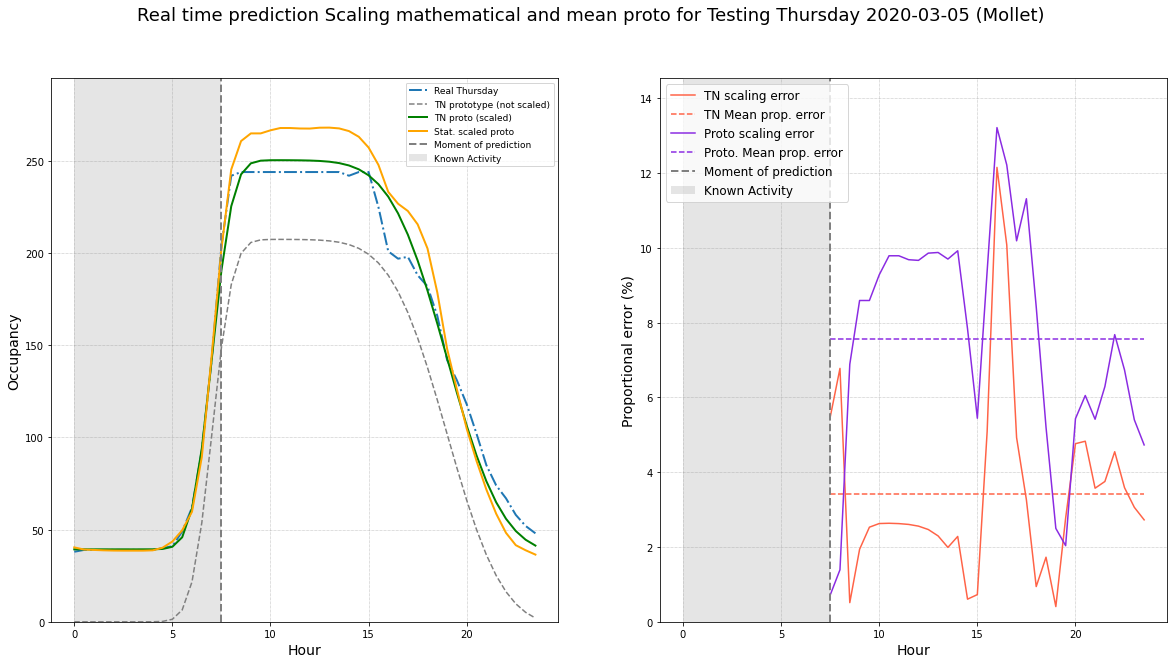

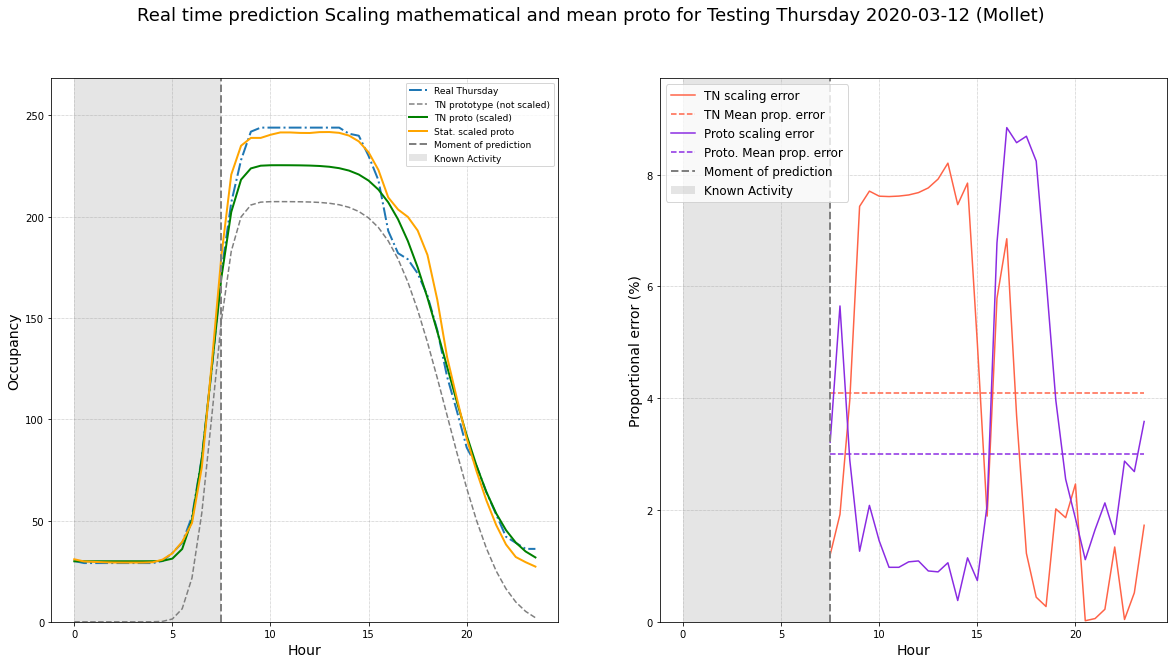

In [60]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], hist_weekday_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

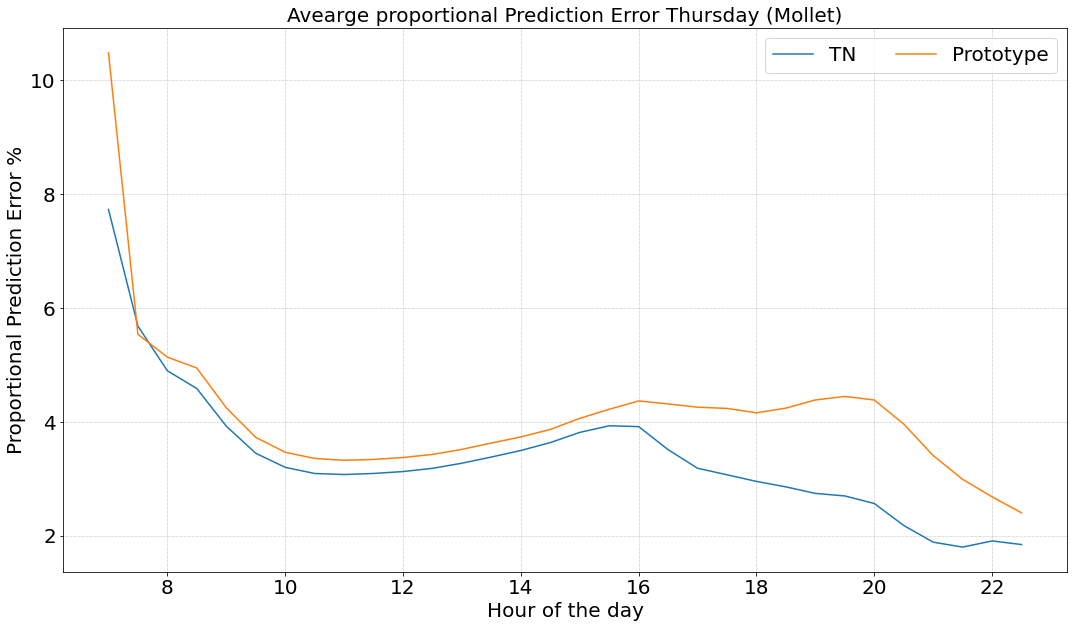

In [61]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,hist_weekday_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

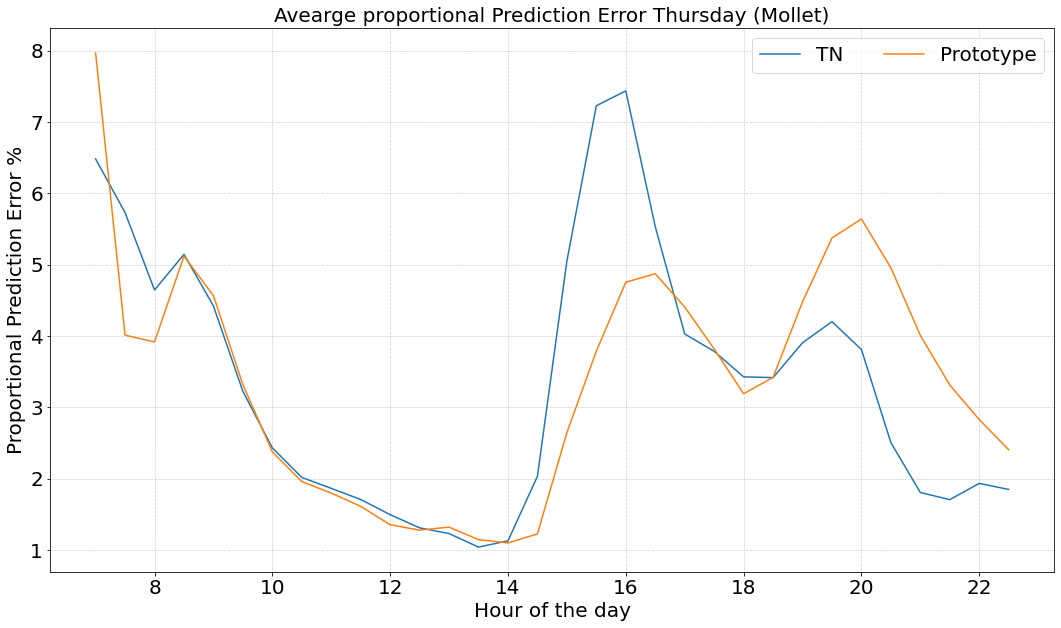

In [62]:
[tn_running_error_vec_now,proto_running_error_vec_now]=calcRunningPredcitionErrorNow(t_days,hist_weekday_proto,
                                                                          tn_proto,max_value,starting_hour,1)
plotRunningPredcitionError(tn_running_error_vec_now,proto_running_error_vec_now,starting_hour,day,current_parking)

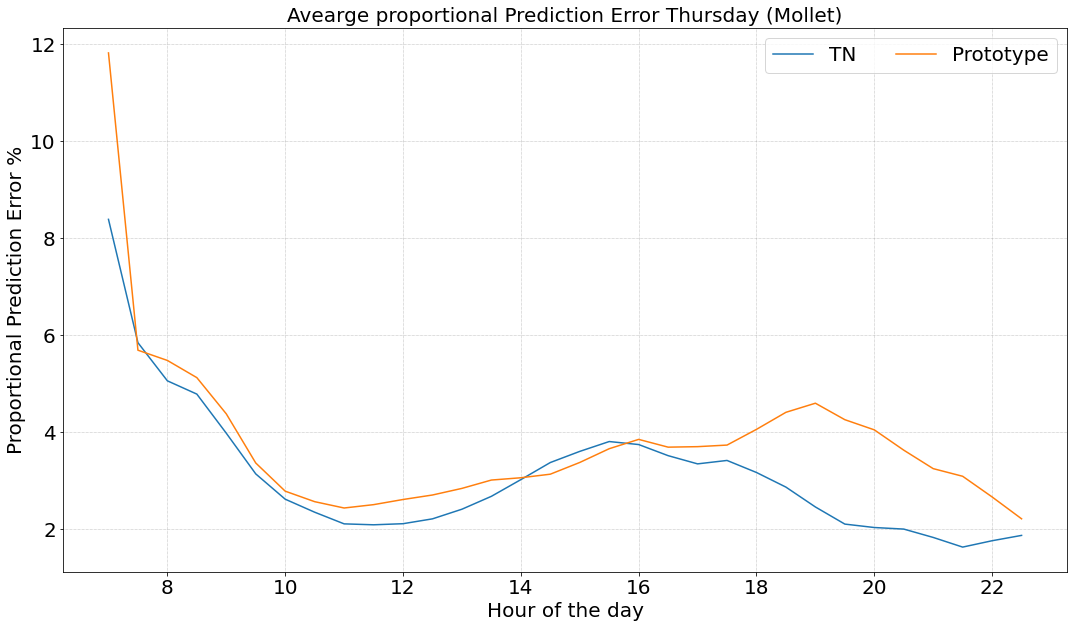

In [63]:
[tn_running_error_vec_med,proto_running_error_vec_med]=calcRunningPredcitionErrorMedian(t_days,hist_weekday_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec_med,proto_running_error_vec_med,starting_hour,day,current_parking)

In [64]:
proto_running_error_wd=np.concatenate((proto_running_error_wd, proto_running_error_vec), axis=1)
tn_running_error_wd=np.concatenate((tn_running_error_wd, tn_running_error_vec), axis=1)

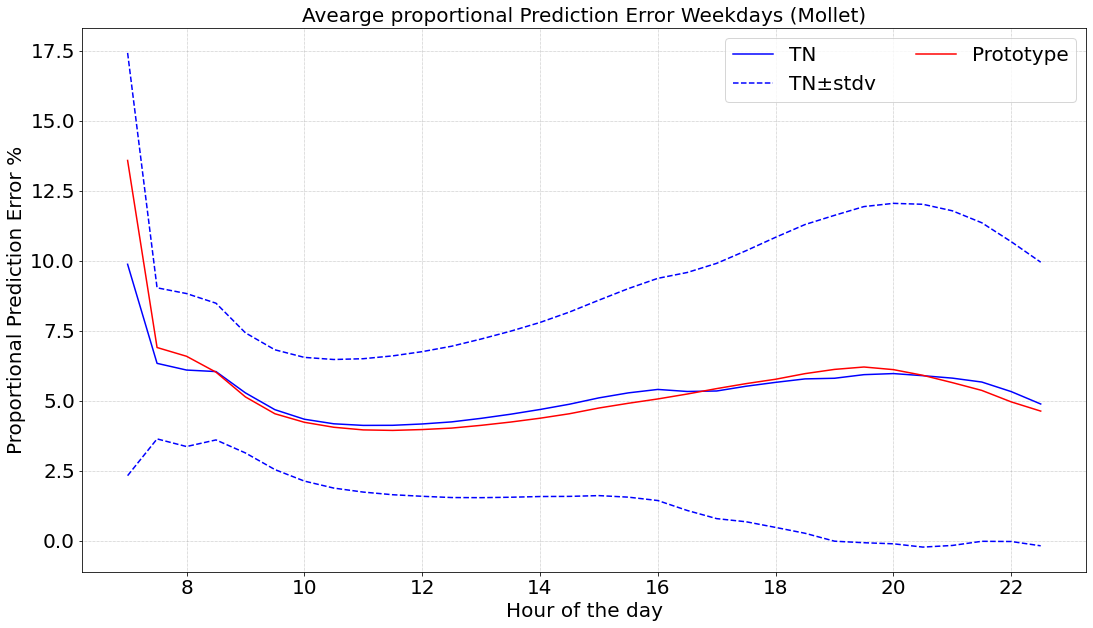

In [65]:
figH=plotRunningPredcitionErrorSTDV(tn_running_error_wd,proto_running_error_wd,starting_hour,"Weekdays",current_parking)

2020-02-27
Real Thursday scaled prototype error:  4.13 %
Real Thursday scaled prototype error (median):  4.25 %
Real Thursday scaled prototype STDV: 1.9280732492112953
Real Thursday scaled TN error:  4.16 %
Real Thursday scaled TN error (median):  4.51 %
Real Thursday scaled TN STDV:  2.0328907646058125
_____________________________________________________________
2020-03-05
Real Thursday scaled prototype error:  9.68 %
Real Thursday scaled prototype error (median):  11.04 %
Real Thursday scaled prototype STDV: 3.4483705821919663
Real Thursday scaled TN error:  9.69 %
Real Thursday scaled TN error (median):  9.88 %
Real Thursday scaled TN STDV:  4.662747057852003
_____________________________________________________________
2020-03-12
Real Thursday scaled prototype error:  3.76 %
Real Thursday scaled prototype error (median):  4.67 %
Real Thursday scaled prototype STDV: 1.6777478283764775
Real Thursday scaled TN error:  3.37 %
Real Thursday scaled TN error (median):  4.15 %
Real Thursd

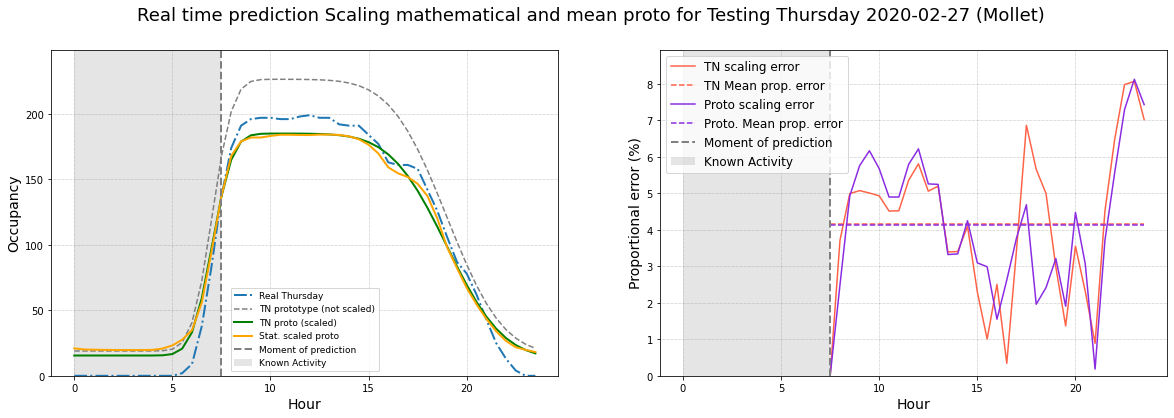

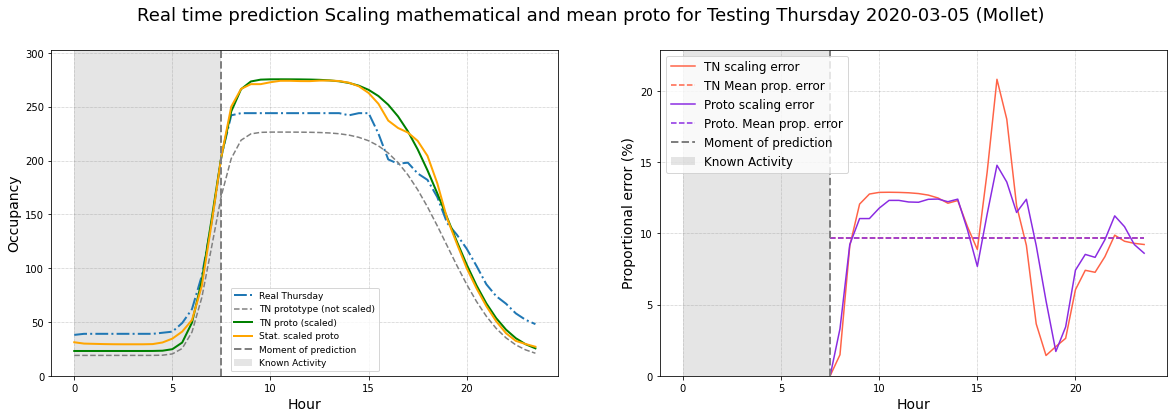

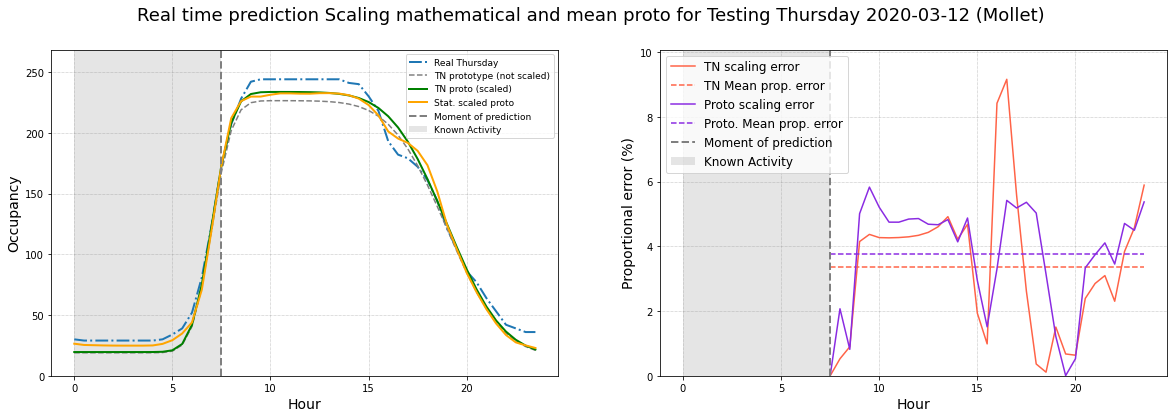

In [66]:
tn_proto = tn_weekday
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1
    

### FRIDAY

In [67]:
statistic_proto = hist_friday_proto
tn_proto = tn_friday_nooff
t_days = testing_fridays
t_dates=testing_fridays_dates
limit_hour = 16
day = 'Friday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-02-28
Real Friday scaled prototype error:  2.15 %
Real Friday scaled prototype error (median):  2.13 %
Real Friday scaled prototype STDV: 0.9762827476990465
Real Friday scaled TN error:  9.05 %
Real Friday scaled TN error (median):  10.56 %
Real Friday scaled TN STDV:  4.9426222440362215
_____________________________________________________________
2020-03-06
Real Friday scaled prototype error:  14.46 %
Real Friday scaled prototype error (median):  14.03 %
Real Friday scaled prototype STDV: 2.415245290843113
Real Friday scaled TN error:  8.45 %
Real Friday scaled TN error (median):  8.58 %
Real Friday scaled TN STDV:  3.3084897013552044
_____________________________________________________________
2020-03-13
Real Friday scaled prototype error:  19.88 %
Real Friday scaled prototype error (median):  20.91 %
Real Friday scaled prototype STDV: 2.174794971353397
Real Friday scaled TN error:  16.84 %
Real Friday scaled TN error (median):  16.64 %
Real Friday scaled TN STDV:  1.130213872

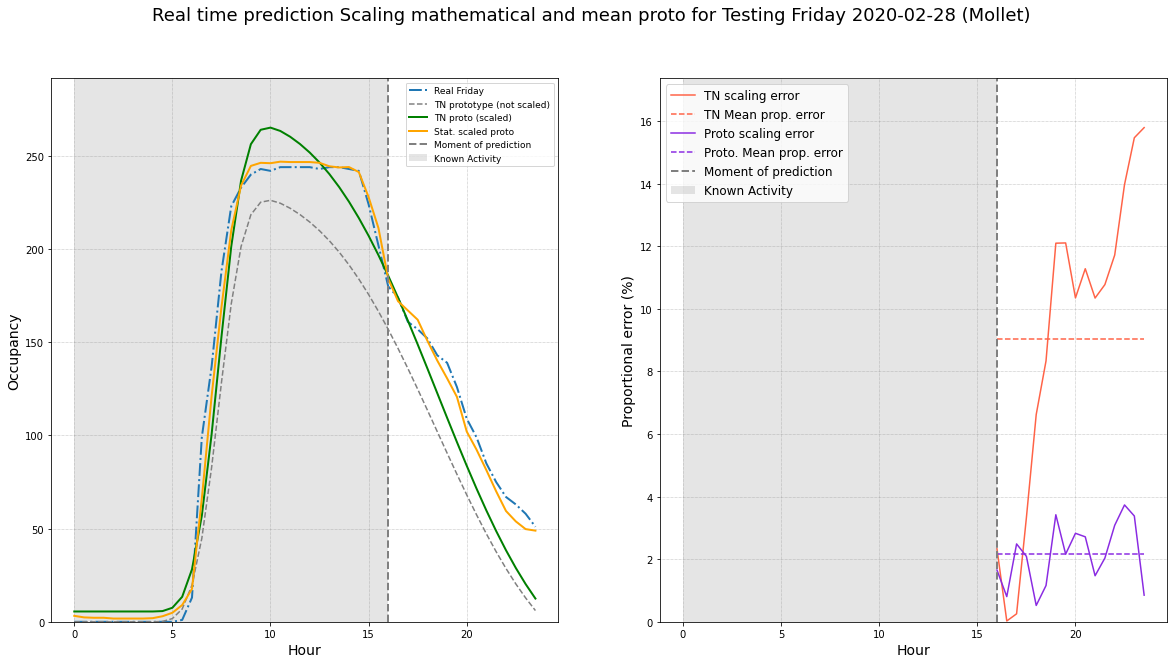

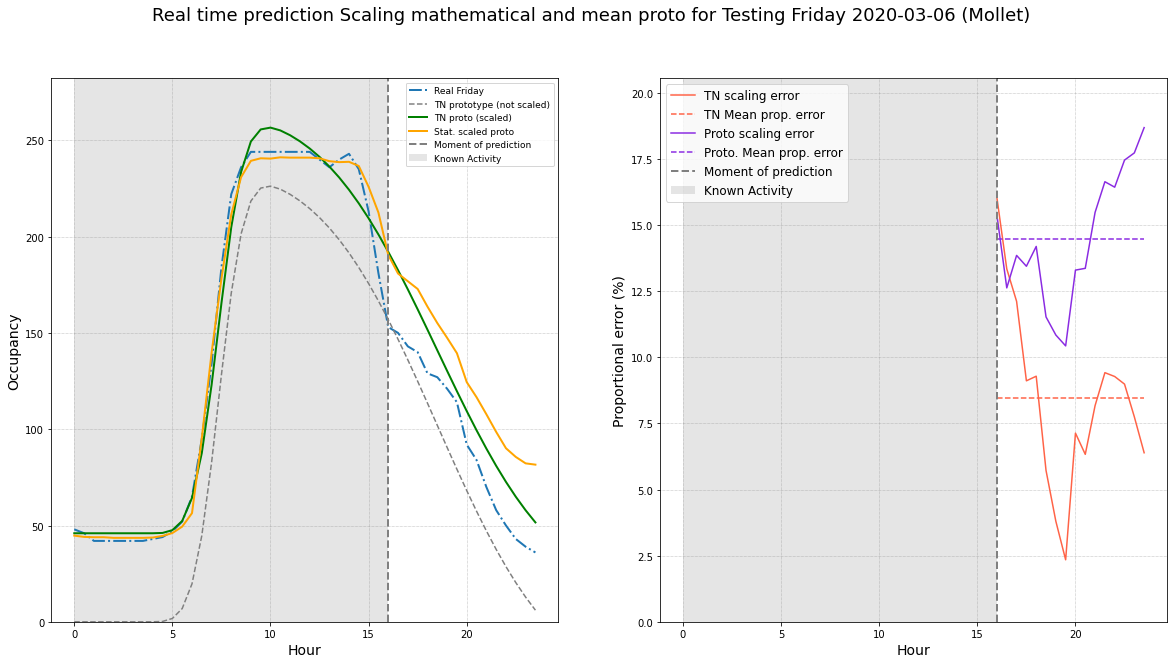

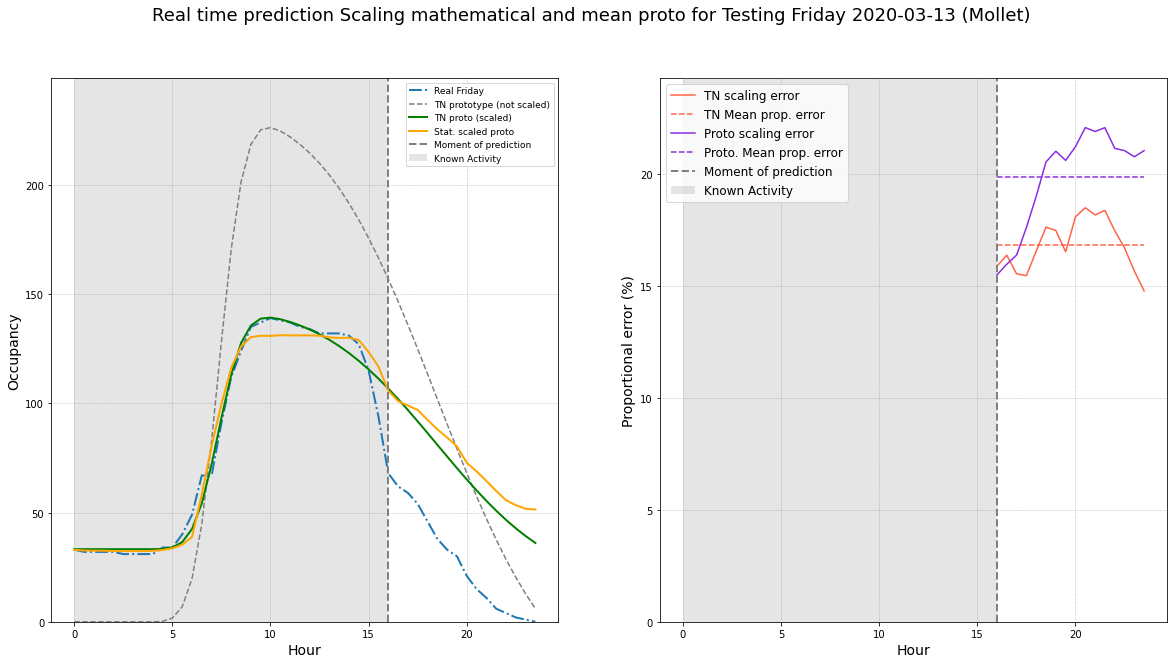

In [68]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], statistic_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

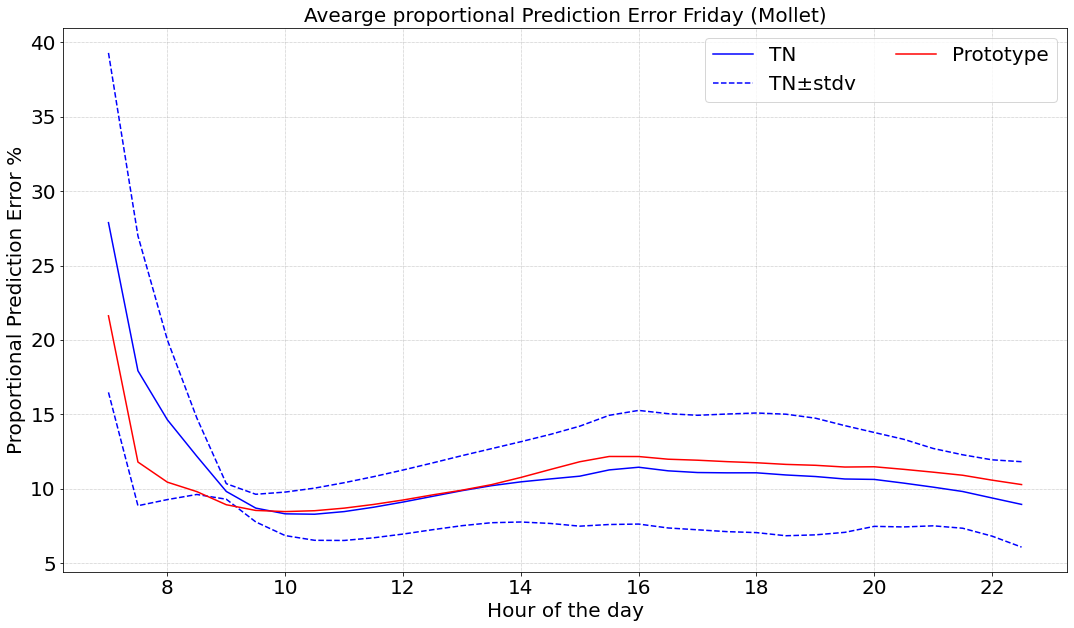

In [69]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,statistic_proto,
                                                                          tn_proto,max_value,starting_hour)
figH=plotRunningPredcitionErrorSTDV(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [70]:
proto_running_error_fr=proto_running_error_vec
tn_running_error_fr=tn_running_error_vec

2020-02-28
Real Friday scaled prototype error:  1.59 %
Real Friday scaled prototype error (median):  1.62 %
Real Friday scaled prototype STDV: 0.8555284119734199
Real Friday scaled TN error:  8.96 %
Real Friday scaled TN error (median):  10.17 %
Real Friday scaled TN STDV:  4.364663546074167
_____________________________________________________________
2020-03-06
Real Friday scaled prototype error:  2.25 %
Real Friday scaled prototype error (median):  1.81 %
Real Friday scaled prototype STDV: 1.307936268589434
Real Friday scaled TN error:  7.25 %
Real Friday scaled TN error (median):  7.1 %
Real Friday scaled TN STDV:  3.2209437466641724
_____________________________________________________________
2020-03-13
Real Friday scaled prototype error:  5.82 %
Real Friday scaled prototype error (median):  6.97 %
Real Friday scaled prototype STDV: 2.974322801525527
Real Friday scaled TN error:  2.88 %
Real Friday scaled TN error (median):  3.14 %
Real Friday scaled TN STDV:  1.7787019955992984


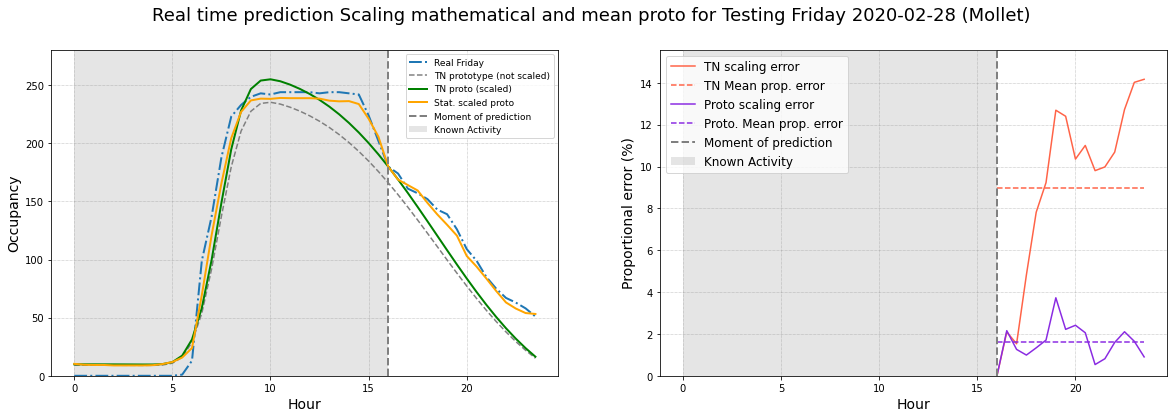

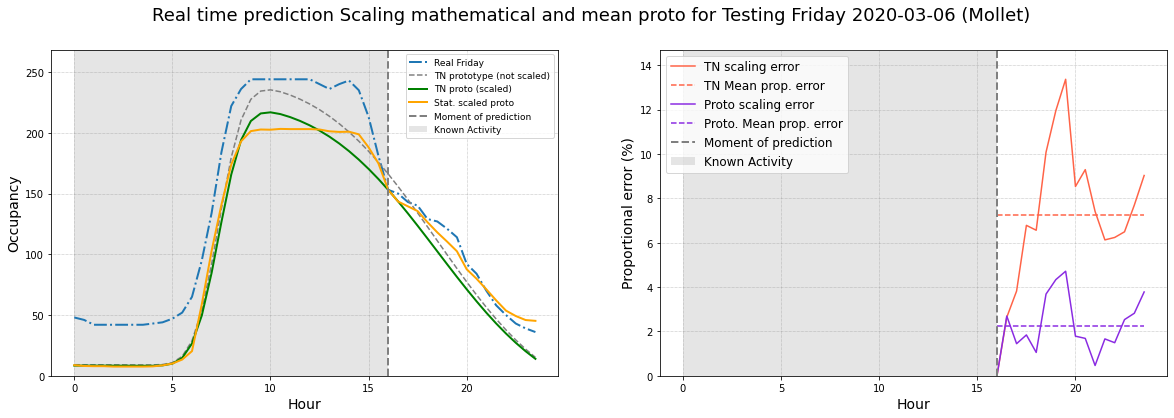

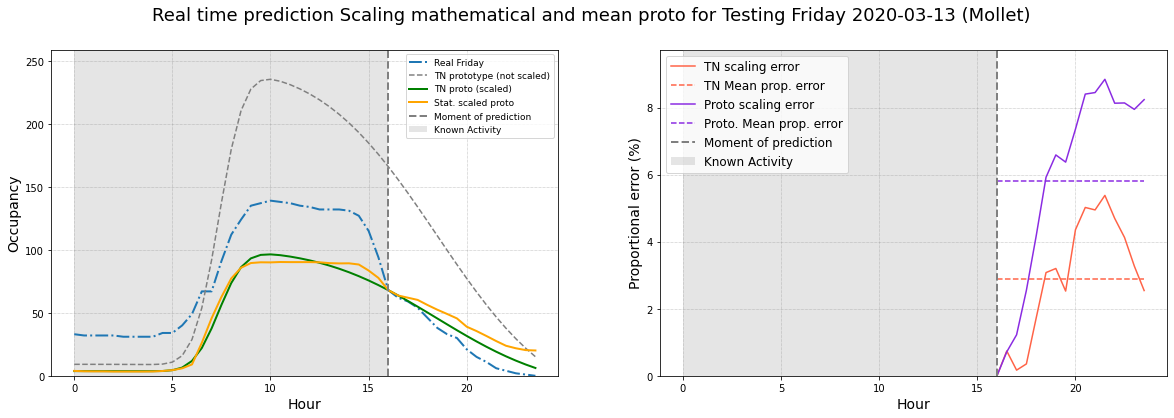

In [71]:
tn_proto = tn_friday 
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], statistic_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = statistic_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1
    

### WEEKEND

### SATURDAY

In [72]:
statistic_proto = hist_weekend_proto
tn_proto = tn1_weekend_nooff
t_days = testing_saturdays
t_dates= testing_saturdays_dates
limit_hour = 16
day = 'Saturday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-02-29
Real Saturday scaled prototype error:  2.39 %
Real Saturday scaled prototype error (median):  1.92 %
Real Saturday scaled prototype STDV: 1.5174121348169725
Real Saturday scaled TN error:  1.49 %
Real Saturday scaled TN error (median):  1.23 %
Real Saturday scaled TN STDV:  1.2059164068255015
_____________________________________________________________
2020-03-07
Real Saturday scaled prototype error:  3.17 %
Real Saturday scaled prototype error (median):  2.33 %
Real Saturday scaled prototype STDV: 2.6588656610806902
Real Saturday scaled TN error:  2.2 %
Real Saturday scaled TN error (median):  2.14 %
Real Saturday scaled TN STDV:  1.6365239670820593
_____________________________________________________________
2020-03-14
Real Saturday scaled prototype error:  2.46 %
Real Saturday scaled prototype error (median):  2.35 %
Real Saturday scaled prototype STDV: 1.2578046950463573
Real Saturday scaled TN error:  2.09 %
Real Saturday scaled TN error (median):  2.35 %
Real Saturda

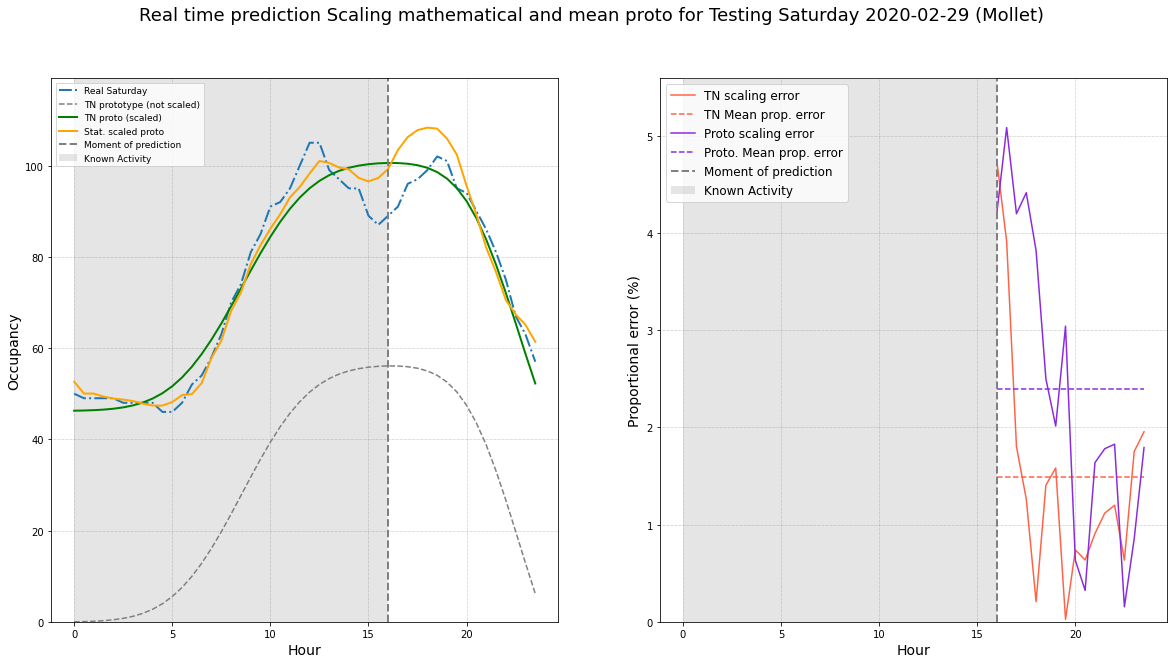

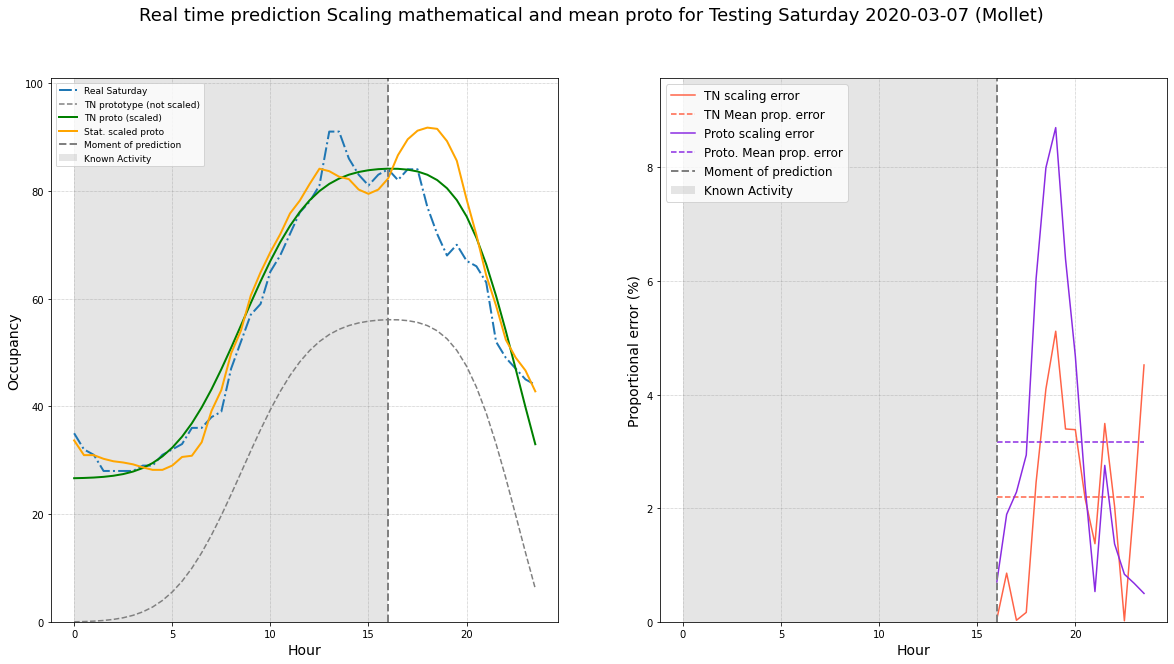

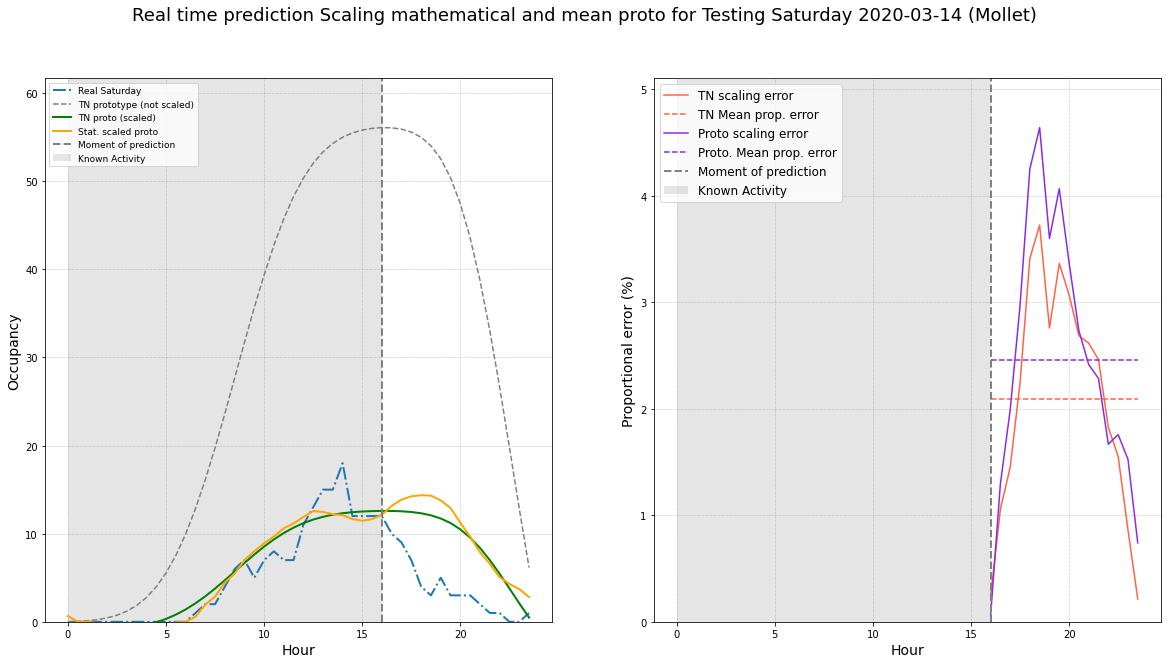

In [73]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], statistic_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

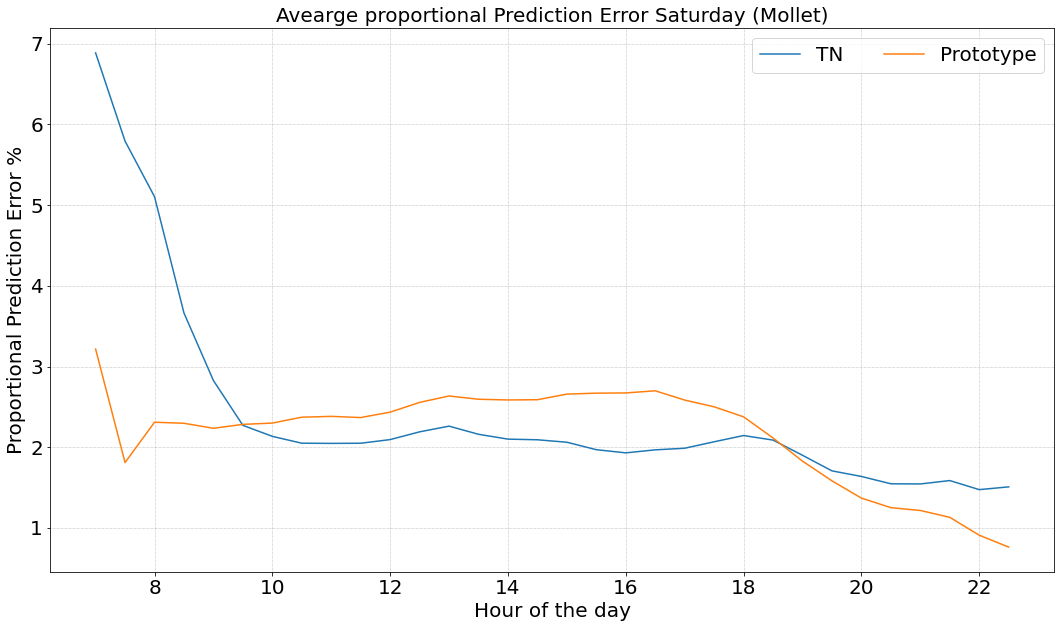

In [74]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,statistic_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [75]:
proto_running_error_we=proto_running_error_vec
tn_running_error_we=tn_running_error_vec

2020-02-29
Real Saturday scaled prototype error:  1.92 %
Real Saturday scaled prototype error (median):  1.32 %
Real Saturday scaled prototype STDV: 1.4145536000335286
Real Saturday scaled TN error:  4.29 %
Real Saturday scaled TN error (median):  5.01 %
Real Saturday scaled TN STDV:  1.6716229865973045
_____________________________________________________________
2020-03-07
Real Saturday scaled prototype error:  4.8 %
Real Saturday scaled prototype error (median):  5.56 %
Real Saturday scaled prototype STDV: 2.184637985997603
Real Saturday scaled TN error:  2.53 %
Real Saturday scaled TN error (median):  2.63 %
Real Saturday scaled TN STDV:  1.772981454316998
_____________________________________________________________
2020-03-14
Real Saturday scaled prototype error:  2.9 %
Real Saturday scaled prototype error (median):  3.31 %
Real Saturday scaled prototype STDV: 1.0890454975706614
Real Saturday scaled TN error:  2.56 %
Real Saturday scaled TN error (median):  3.06 %
Real Saturday s

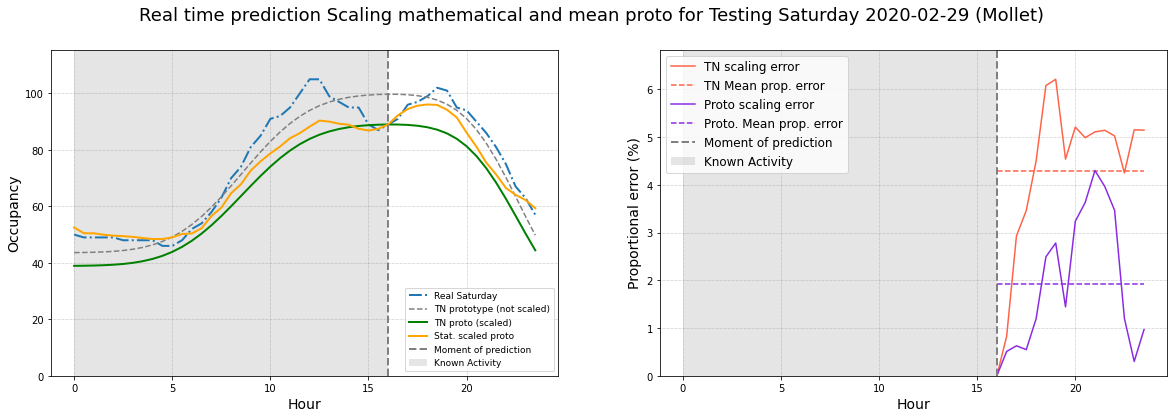

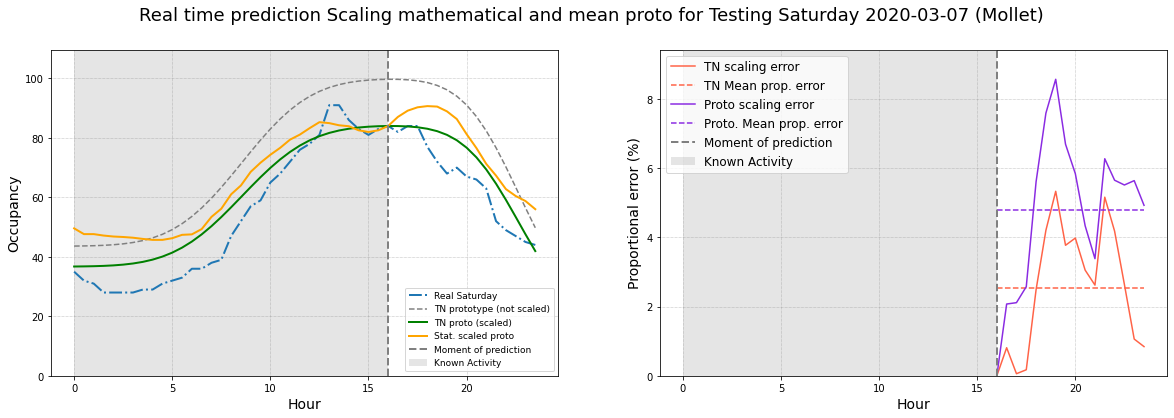

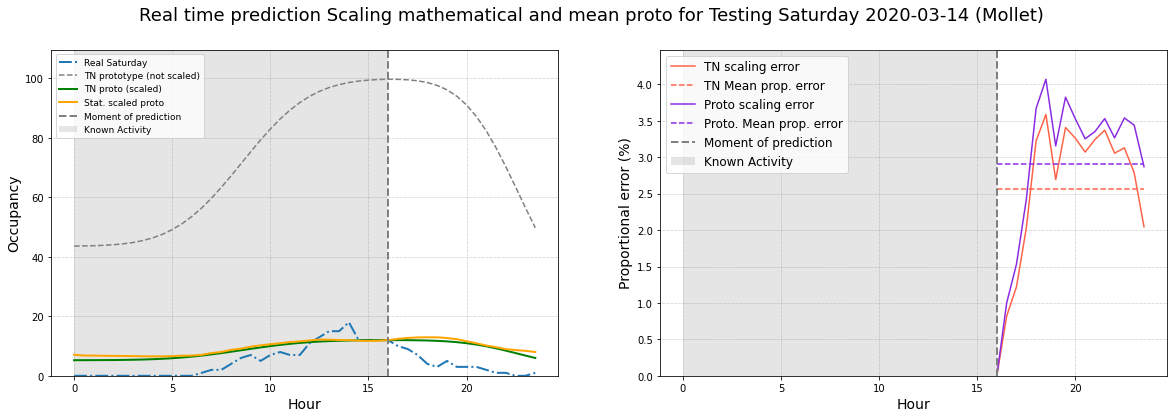

In [76]:
tn_proto = tn1_weekend        
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], statistic_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = statistic_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    #ax[0].set_ylim([0,axis_ylim_we])
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

### SUNDAY

In [77]:
statistic_proto = hist_weekend_proto
tn_proto = tn1_weekend_nooff
t_days = testing_sundays
t_dates= testing_sundays_dates
limit_hour = 13
day = 'Sunday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0
    

2020-03-01
Real Sunday scaled prototype error:  2.79 %
Real Sunday scaled prototype error (median):  2.77 %
Real Sunday scaled prototype STDV: 1.5283547838953098
Real Sunday scaled TN error:  2.5 %
Real Sunday scaled TN error (median):  2.26 %
Real Sunday scaled TN STDV:  1.6494502724580709
_____________________________________________________________
2020-03-08
Real Sunday scaled prototype error:  6.57 %
Real Sunday scaled prototype error (median):  5.71 %
Real Sunday scaled prototype STDV: 5.10454055650916
Real Sunday scaled TN error:  6.64 %
Real Sunday scaled TN error (median):  4.98 %
Real Sunday scaled TN STDV:  5.335271398945261
_____________________________________________________________
2020-03-15
Real Sunday scaled prototype error:  0.57 %
Real Sunday scaled prototype error (median):  0.45 %
Real Sunday scaled prototype STDV: 0.4101311561842751
Real Sunday scaled TN error:  0.52 %
Real Sunday scaled TN error (median):  0.47 %
Real Sunday scaled TN STDV:  0.3893504245734684
_

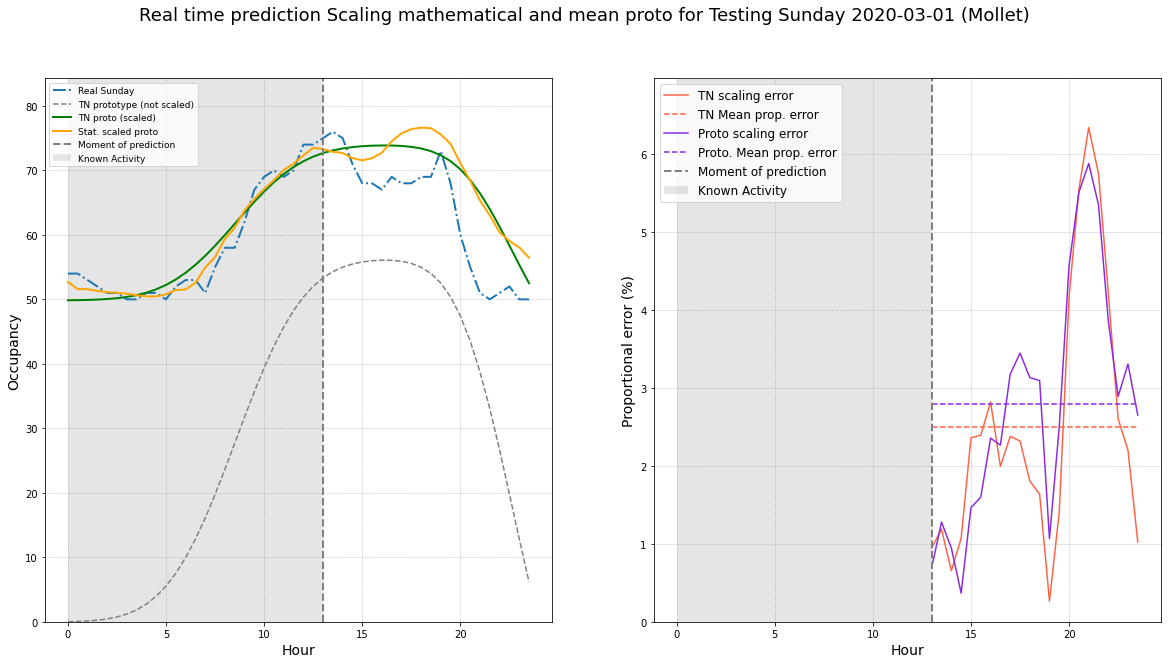

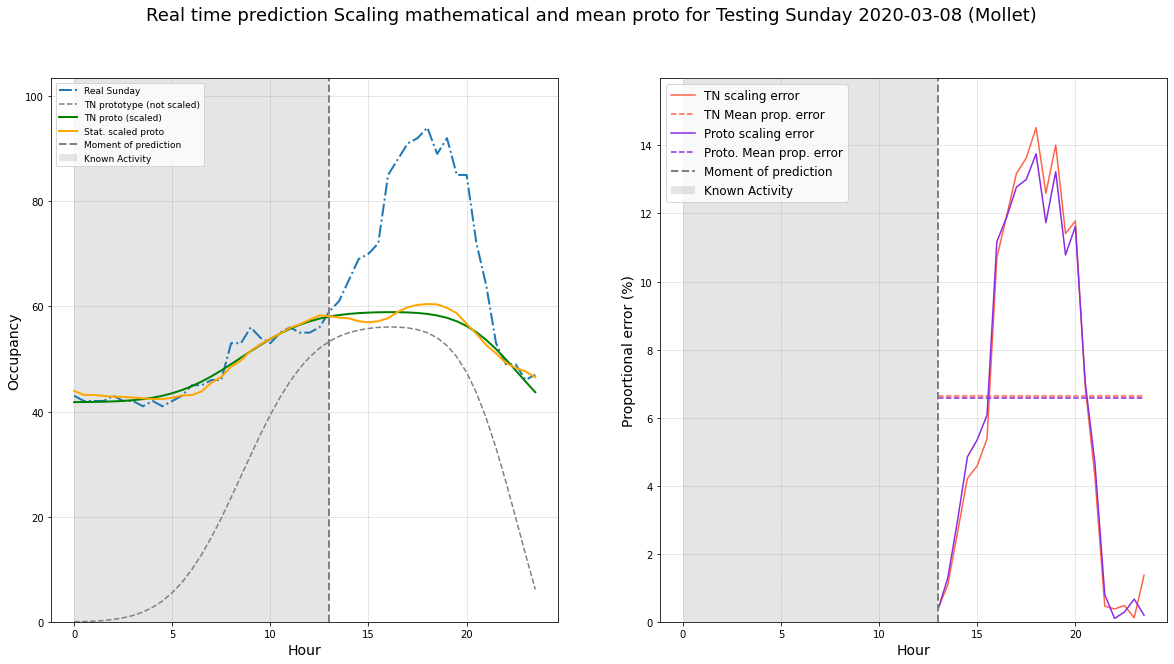

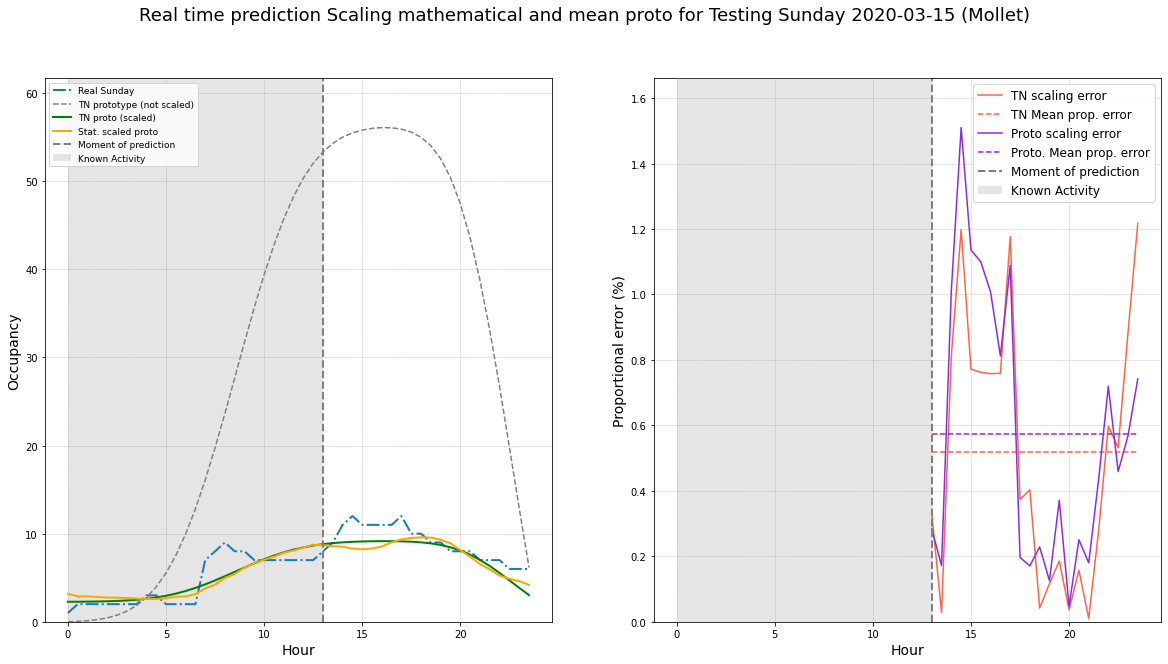

In [78]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], statistic_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

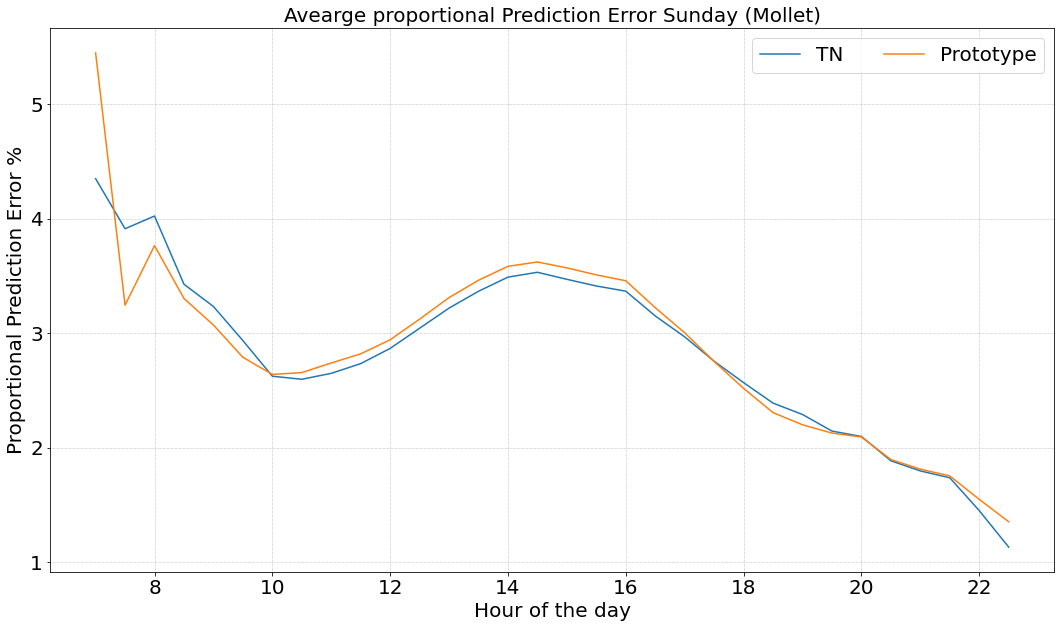

In [79]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,statistic_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [80]:
proto_running_error_we=np.concatenate((proto_running_error_we, proto_running_error_vec), axis=1)
tn_running_error_we=np.concatenate((tn_running_error_we, tn_running_error_vec), axis=1)

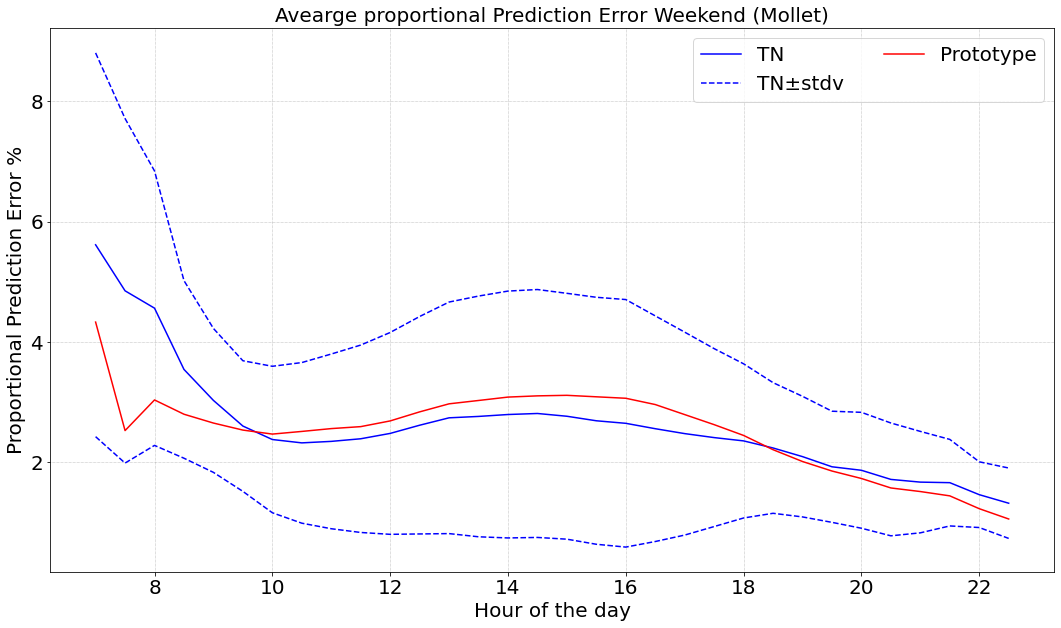

In [81]:
figH=plotRunningPredcitionErrorSTDV(tn_running_error_we,proto_running_error_we,starting_hour,"Weekend",current_parking)

2020-03-01
Real Sunday scaled prototype error:  2.62 %
Real Sunday scaled prototype error (median):  2.59 %
Real Sunday scaled prototype STDV: 1.7607806391564602
Real Sunday scaled TN error:  2.8 %
Real Sunday scaled TN error (median):  3.16 %
Real Sunday scaled TN STDV:  1.566382990350336
_____________________________________________________________
2020-03-08
Real Sunday scaled prototype error:  6.85 %
Real Sunday scaled prototype error (median):  5.98 %
Real Sunday scaled prototype STDV: 4.268882502800083
Real Sunday scaled TN error:  7.23 %
Real Sunday scaled TN error (median):  6.26 %
Real Sunday scaled TN STDV:  4.530147648992065
_____________________________________________________________
2020-03-15
Real Sunday scaled prototype error:  0.62 %
Real Sunday scaled prototype error (median):  0.38 %
Real Sunday scaled prototype STDV: 0.5399829647810583
Real Sunday scaled TN error:  0.67 %
Real Sunday scaled TN error (median):  0.52 %
Real Sunday scaled TN STDV:  0.46454123735626446


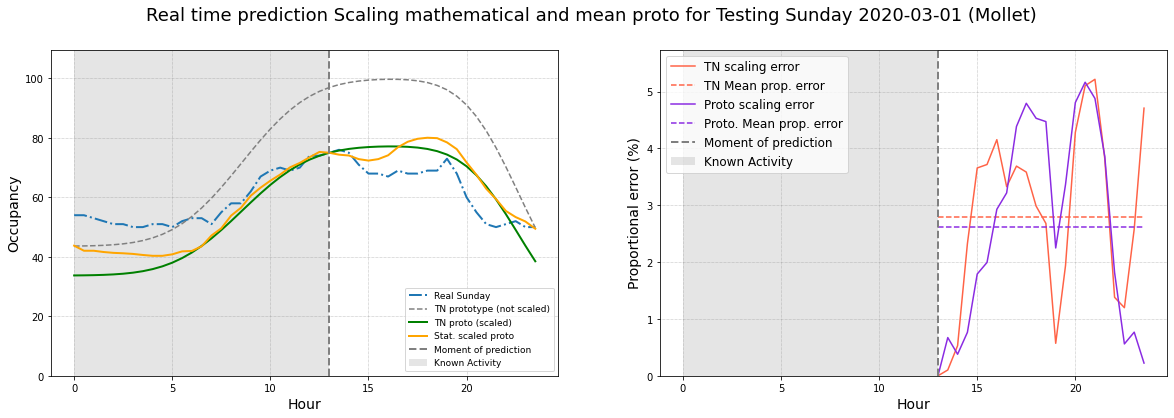

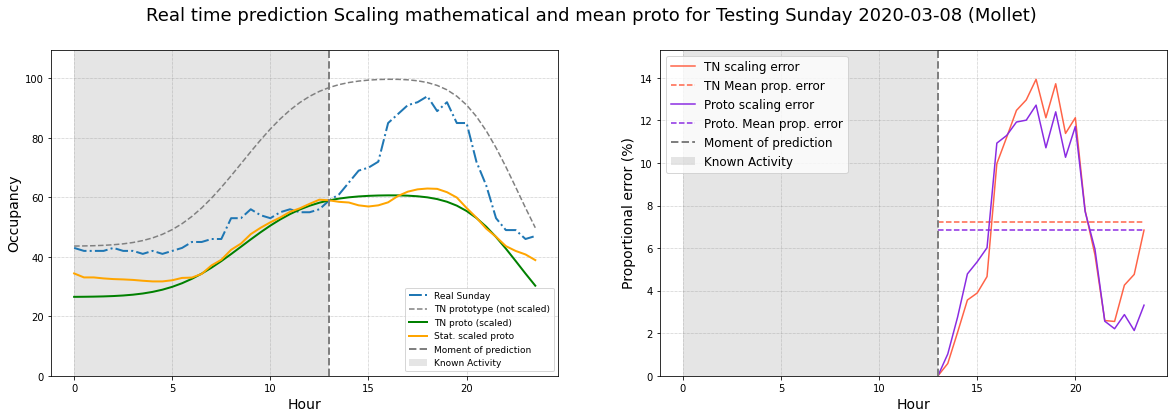

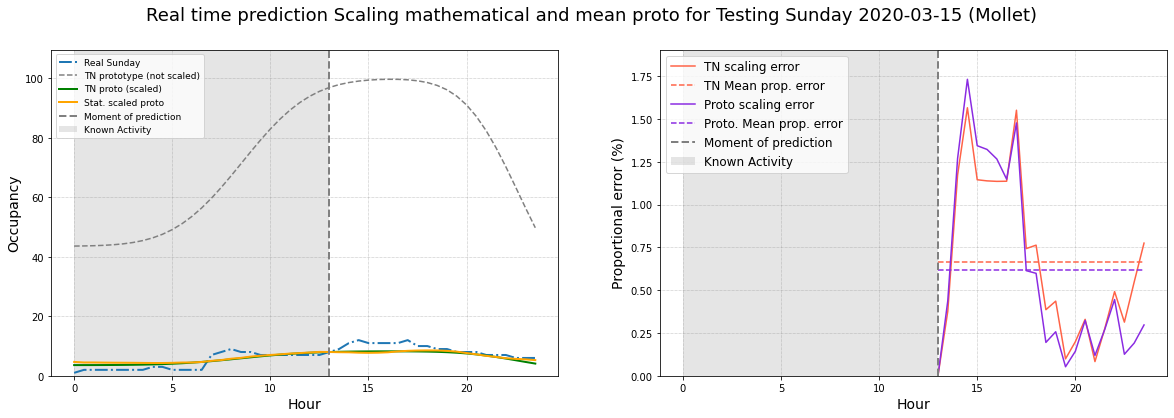

In [82]:
tn_proto = tn1_weekend
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], statistic_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = statistic_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    #ax[0].set_ylim([0,axis_ylim_we])
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

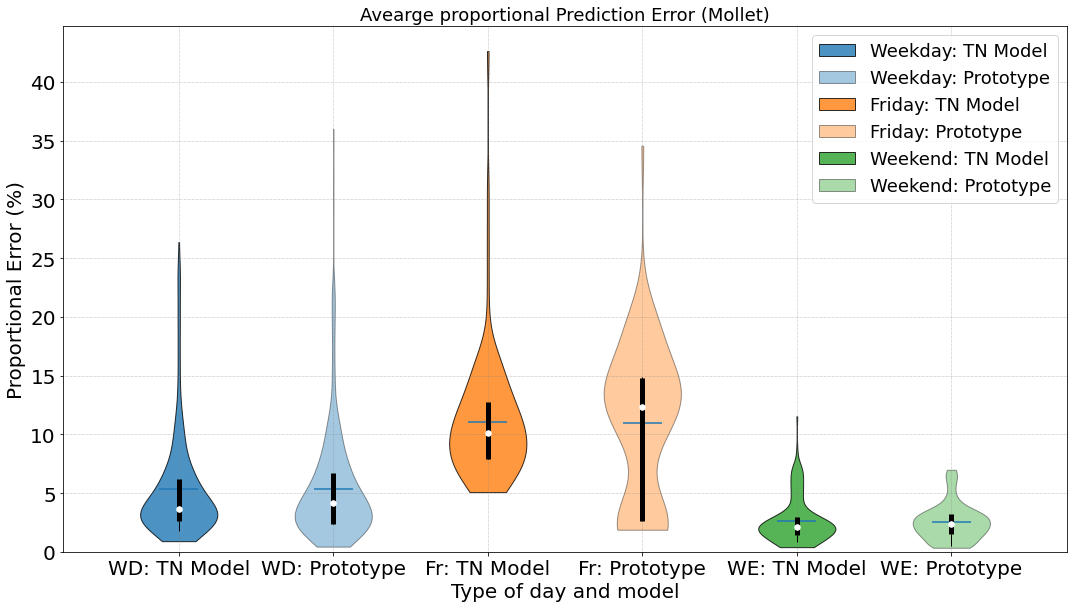

In [83]:
data = [tn_running_error_wd.flatten(),proto_running_error_wd.flatten(),
        tn_running_error_fr.flatten(),proto_running_error_fr.flatten(),
        tn_running_error_we.flatten(),proto_running_error_we.flatten()]

bd='#1f77b4'
rd='#ff7f0e'
gd='#2ca02c'
color_vec=[bd,rd,gd]
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(18,10), sharey=True)
#ax1.set_title('Default violin plot')
#ax1.set_ylabel('Observed values')
#ax1.violinplot(data)

ax2.set_title("Avearge proportional Prediction Error ("+ current_parking+')', fontsize=fsize)
parts = ax2.violinplot(
        data, showmeans=True, showmedians=False,
        showextrema=False)

cc=0
for pc in parts['bodies']:
    cc=cc+1
    if cc%2==0:
        pc.set_facecolor('#D43F3A')
        pc.set_facecolor(color_vec[int((cc-2)/2)])
        pc.set_alpha(.4)
    else:
        pc.set_facecolor(color_vec[int((cc-1)/2)])
        pc.set_alpha(.8)
    pc.set_edgecolor('black')


quartile1wd, medianswd, quartile3wd = np.percentile([tn_running_error_wd.flatten(),proto_running_error_wd.flatten()], [25, 50, 75], axis=1)
quartile1fr, mediansfr, quartile3fr = np.percentile([tn_running_error_fr.flatten(),proto_running_error_fr.flatten()], [25, 50, 75], axis=1)
quartile1we, medianswe, quartile3we = np.percentile([tn_running_error_we.flatten(),proto_running_error_we.flatten()], [25, 50, 75], axis=1)

quartile1=np.concatenate((quartile1wd, quartile1fr,quartile1we), axis=0)
medians=np.concatenate((medianswd, mediansfr,medianswe), axis=0)
quartile3=np.concatenate((quartile3wd, quartile3fr,quartile3we), axis=0)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax2.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax2.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax2.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

# set style for the axes
labels = ['WD: TN Model', 'WD: Prototype','Fr: TN Model', 'Fr: Prototype','WE: TN Model', 'WE: Prototype']
#for ax in [ax1, ax2]:
set_axis_style(ax2, labels)

ax2.legend(['Weekday: TN Model','Weekday: Prototype','Friday: TN Model','Friday: Prototype',
           'Weekend: TN Model','Weekend: Prototype'], fontsize=fsize)
#ax2.tick_params(axis='y', labelsize=20)
plt.subplots_adjust(bottom=0.15, wspace=0.05)
plt.show()
fig.savefig('RunningPredictionError_'+current_parking+'_violin.pdf',bbox_inches='tight');

In [84]:
#figH=plotRunningPredcitionErrorAgg(tn_running_error_wd,proto_running_error_wd,tn_running_error_fr,
#                                  proto_running_error_fr,tn_running_error_we,proto_running_error_we,
#                                  starting_hour,current_parking,False)
#figH.savefig('RunningPredictionError_'+current_parking+'.pdf',bbox_inches='tight');


## Running  Prediction

In [85]:
day_indexes = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
tn_proto_dict={}
tn_proto_dict["Monday"] = tn_weekday_nooff
tn_proto_dict["Tuesday"] = tn_weekday_nooff
tn_proto_dict["Wednesday"] = tn_weekday_nooff
tn_proto_dict["Thursday"] = tn_weekday_nooff
tn_proto_dict["Friday"] = tn_friday_nooff
tn_proto_dict["Saturday"] = tn1_weekend_nooff
tn_proto_dict["Sunday"] = tn1_weekend_nooff

t_days_dict={}
t_days_dict["Monday"] = testing_mondays
t_days_dict["Tuesday"] = testing_tuesdays
t_days_dict["Wednesday"] = testing_wednesdays
t_days_dict["Thursday"] = testing_thursdays
t_days_dict["Friday"] = testing_fridays
t_days_dict["Saturday"] = testing_saturdays
t_days_dict["Sunday"] = testing_sundays

hist_proto_dict={}
hist_proto_dict["Monday"] = hist_weekday_proto
hist_proto_dict["Tuesday"] = hist_weekday_proto
hist_proto_dict["Wednesday"] = hist_weekday_proto
hist_proto_dict["Thursday"] = hist_weekday_proto
hist_proto_dict["Friday"] = hist_friday_proto
hist_proto_dict["Saturday"] = hist_weekend_proto
hist_proto_dict["Sunday"] = hist_weekend_proto

#predWindow_vec=[0.5, 1, 1.5, 2, 2.5, 3] 
predWindow_vec=[1, 2, 3] 

pred_error_array=np.zeros([len(predWindow_vec),len(day_indexes),])
pred_error_array_stdv=np.zeros([len(predWindow_vec),len(day_indexes),])
pred_error_array_proto=np.zeros([len(predWindow_vec),len(day_indexes),])
pred_error_array_proto_stdv=np.zeros([len(predWindow_vec),len(day_indexes),])

proto_running_errorNOW_wd=[None] * len(predWindow_vec)
tn_running_errorNOW_wd=[None] *  len(predWindow_vec)
proto_running_errorNOW_fr=[None] * len(predWindow_vec)
tn_running_errorNOW_fr=[None] * len(predWindow_vec)
proto_running_errorNOW_we=[None] * len(predWindow_vec)
tn_running_errorNOW_we=[None] * len(predWindow_vec)


starting_hour=7
for i in range(0,len(day_indexes)):
    day=day_indexes[i]
    tn_proto=tn_proto_dict[day]
    t_days=t_days_dict[day]
    hist_proto=hist_proto_dict[day]
    j=0
    for pred_window in predWindow_vec:
        [tn_running_error_vec_now,proto_running_error_vec_now]=calcRunningPredcitionErrorNow(t_days,hist_proto,
                                                                                             tn_proto,max_value,starting_hour,pred_window)
        if day=='Monday':
            proto_running_errorNOW_wd[j]=proto_running_error_vec_now
            tn_running_errorNOW_wd[j]=tn_running_error_vec_now
        elif day in ['Tuesday','Wednesday','Thursday']:
            proto_running_errorNOW_wd[j]=np.concatenate((proto_running_errorNOW_wd[j], proto_running_error_vec_now), axis=1)
            tn_running_errorNOW_wd[j]=np.concatenate((tn_running_errorNOW_wd[j], tn_running_error_vec_now), axis=1)
        elif day == 'Friday':
            proto_running_errorNOW_fr[j]=proto_running_error_vec_now
            tn_running_errorNOW_fr[j]=tn_running_error_vec_now
        elif day == 'Saturday':
            proto_running_errorNOW_we[j]=proto_running_error_vec_now
            tn_running_errorNOW_we[j]=tn_running_error_vec_now
        else:
            proto_running_errorNOW_we[j]=np.concatenate((proto_running_errorNOW_we[j], proto_running_error_vec_now), axis=1)
            tn_running_errorNOW_we[j]=np.concatenate((tn_running_errorNOW_we[j], tn_running_error_vec_now), axis=1)
            
            
        pred_error_array[j,i]=np.mean(tn_running_error_vec_now)
        pred_error_array_proto[j,i]=np.mean(proto_running_error_vec_now)
        pred_error_array_stdv[j,i]=np.std(tn_running_error_vec_now)
        pred_error_array_proto_stdv[j,i]=np.std(tn_running_error_vec_now)
        
        j=j+1
        #plotRunningPredcitionError(tn_running_error_vec_now,proto_running_error_vec_now,starting_hour,day,current_parking)

In [86]:
tn_running_error_wd=tn_running_errorNOW_wd[0]
tn_running_error_fr=tn_running_errorNOW_fr[0]
tn_running_error_we=tn_running_errorNOW_we[0]
proto_running_error_wd=proto_running_errorNOW_wd[0]
proto_running_error_fr=proto_running_errorNOW_fr[0]
proto_running_error_we=proto_running_errorNOW_we[0]

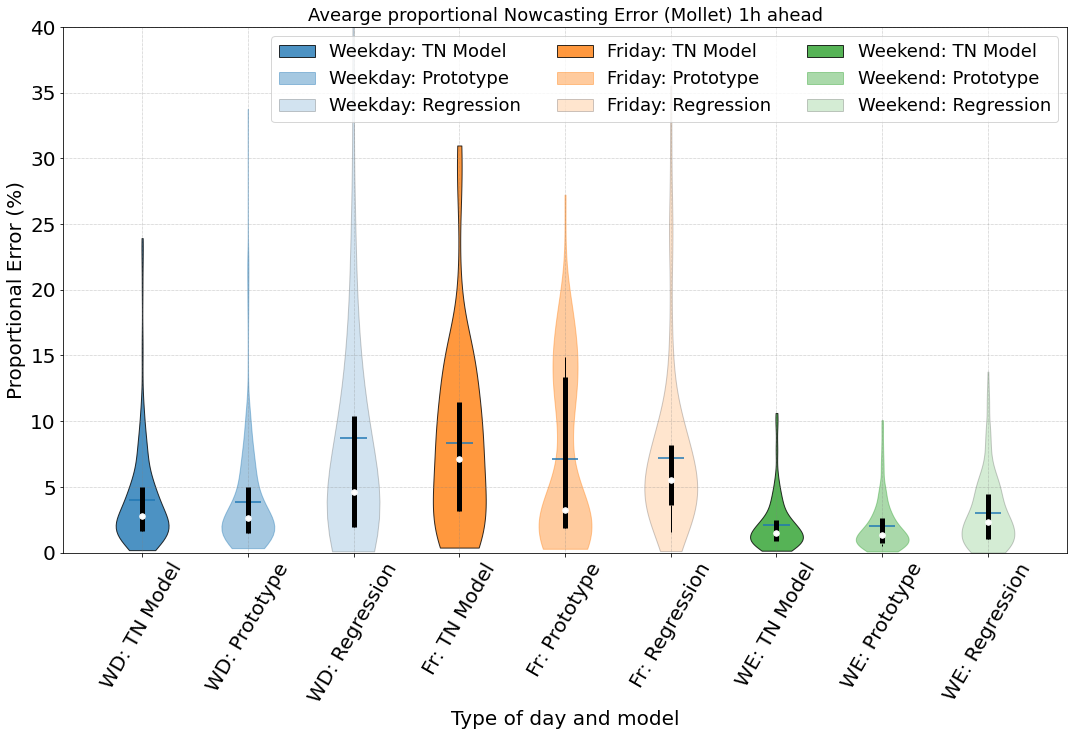

In [87]:
data = [tn_running_error_wd.flatten(),proto_running_error_wd.flatten(),reg_running_error_wd.flatten()*100,
        tn_running_error_fr.flatten(),proto_running_error_fr.flatten(),reg_running_error_fr.flatten()*100,
        tn_running_error_we.flatten(),proto_running_error_we.flatten(),reg_running_error_we.flatten()*100]

bd='#1f77b4'
rd='#ff7f0e'
gd='#2ca02c'
color_vec=[bd,rd,gd]
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(18,10), sharey=True)
#ax1.set_title('Default violin plot')
#ax1.set_ylabel('Observed values')
#ax1.violinplot(data)

ax2.set_title("Avearge proportional Nowcasting Error ("+ current_parking+') 1h ahead', fontsize=fsize)
parts = ax2.violinplot(
        data, showmeans=True, showmedians=False,
        showextrema=False)

cc=0
for pc in parts['bodies']:
    cc=cc+1
    if cc%3==2:
        #pc.set_facecolor('#D43F3A')
        pc.set_facecolor(color_vec[int((cc-1)/3)])
        pc.set_alpha(.4)
        pc.set_edgecolor(color_vec[int((cc-1)/3)])
    elif cc%3==1:
        pc.set_facecolor(color_vec[int((cc-1)/3)])
        pc.set_alpha(.8)
        pc.set_edgecolor('black')
    else:
        pc.set_facecolor(color_vec[int((cc-1)/3)])
        pc.set_alpha(.2)
        pc.set_edgecolor('black')

  
    
quartile1wd, medianswd, quartile3wd = np.percentile([tn_running_error_wd.flatten(),proto_running_error_wd.flatten(),
                                                     reg_running_error_wd.flatten()*100], [25, 50, 75], axis=1)
quartile1fr, mediansfr, quartile3fr = np.percentile([tn_running_error_fr.flatten(),proto_running_error_fr.flatten(),
                                                     reg_running_error_fr.flatten()*100], [25, 50, 75], axis=1)
quartile1we, medianswe, quartile3we = np.percentile([tn_running_error_we.flatten(),proto_running_error_we.flatten(),
                                                     reg_running_error_we.flatten()*100], [25, 50, 75], axis=1)

quartile1=np.concatenate((quartile1wd, quartile1fr,quartile1we), axis=0)
medians=np.concatenate((medianswd, mediansfr,medianswe), axis=0)
quartile3=np.concatenate((quartile3wd, quartile3fr,quartile3we), axis=0)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax2.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax2.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax2.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

# set style for the axes
labels = ['WD: TN Model', 'WD: Prototype','WD: Regression',
          'Fr: TN Model', 'Fr: Prototype','Fr: Regression',
          'WE: TN Model', 'WE: Prototype','WE: Regression']
#for ax in [ax1, ax2]:
set_axis_style(ax2, labels)
plt.xticks(rotation =60)

ax2.legend(['Weekday: TN Model','Weekday: Prototype','Weekday: Regression',
            'Friday: TN Model','Friday: Prototype','Friday: Regression',
           'Weekend: TN Model','Weekend: Prototype','Weekend: Regression'], fontsize=fsize,ncol=3)
#ax2.tick_params(axis='y', labelsize=20)
if ax2.get_ylim()[1]>40 :
    plt.ylim([0,40])
if current_parking_ix==0:
    plt.ylim([0,12])
    
plt.subplots_adjust(bottom=0.15, wspace=0.05)
plt.show()
fig.savefig('RunningPredictionErrorREG_'+current_parking+'_violin_NOW1h.pdf',bbox_inches='tight');

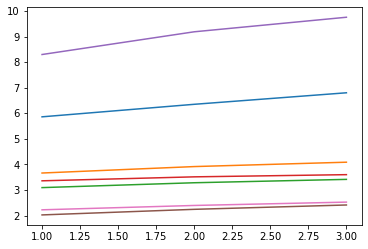

In [88]:
plt.plot(predWindow_vec,pred_error_array)


In [89]:
m_row_runPred

NameError: name 'm_row_runPred' is not defined

In [ ]:
m_row_runPred=[current_parking,'meanE_tn'] + pred_error_array[0,].tolist()
s_row_runPred=[current_parking,'mStdvE_tn'] + pred_error_array_stdv[0,].tolist()
m_row_runPred_proto=[current_parking,'meanE_proto'] + pred_error_array_proto[0,].tolist()
s_row_runPred_proto=[current_parking,'mStdvE_proto'] + pred_error_array_proto_stdv[0,].tolist()



In [ ]:
f = open('data/'+current_parking+'_runnError_1h.csv', 'w')
# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
writer.writerow(m_row_runPred)
writer.writerow(s_row_runPred)
writer.writerow(m_row_runPred_proto)
writer.writerow(s_row_runPred_proto)

# close the file
f.close()